# Accesos al buffer: Lecturas y Escrituras

In [1]:
import os
import pickle as pickle
import tensorflow as tf
import numpy as np
from Nets_original  import GetNeuralNetworkModel
from Stats import WeightQuantization, ActivationStats, CheckAccuracyAndLoss, QuantizationEffect, GetReadAndWrites
from Training import GetDatasets
from Simulation import get_all_outputs
from Simulation import buffer_simulation, save_obj, load_obj
from funciones import compilNet, same_elements
import pandas as pd
from datetime import datetime
from pandas import ExcelWriter
from openpyxl import Workbook
from openpyxl import load_workbook
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt




Con el siguiente bloque obtiene  el número de lecturas y escrituras por posición de memoria tanto usando los experimentos sin usarlos

In [2]:
from Simulation import buffer_simulation, save_obj, load_obj
locs=load_obj('Data/Fault Characterization/variante_mask_vc_707/error_mask_x/error_mask_x/vc_707/locs_054')
error_mask=load_obj('Data/Fault Characterization/variante_mask_vc_707/error_mask_x/error_mask_x//vc_707/error_mask_054')
#error_mask=error_mask[0:10]
print(error_mask[0:10])
print(locs[0:10])
#error_mask=error_mask[9000:9010]
#locs=locs[0:10]
print(len(locs))
print(len(error_mask))

['xxxxxxxxx0xxxxxx', 'x0xxxxxxxxxxxxxx', 'xxxxxxxxx0xxxxxx', 'x0xxxxxxxxxxxxxx', 'xxxxxxxxx0xxxxxx', 'x0xxxxxxxxxxxxxx', 'xxxxxxxxx0xxxxxx', 'x0xxxxxxxxxxxxxx', 'xxxxxxxxx1xxxxxx', 'x0xxxxxxxxxxxxxx']
[4141, 4142, 4181, 4182, 4199, 4200, 4241, 4242, 4249, 4250]
9439
9439


# AlexNet

In [3]:

word_size  = 16
afrac_size = 11  
aint_size  = 4
wfrac_size = 11
wint_size  = 4
trainBatchSize = testBatchSize = 10
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (227, 227), 8, trainBatchSize, testBatchSize)


cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'AlexNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [21]:
def Graficar(Experiment_Acceses):
    
        plt.figure(figsize=(15, 5))
        plt.stackplot(Experiment_Acceses.to_dict()['index'].values(),
                      Experiment_Acceses.to_dict()['Lecturas'].values(),
                      Experiment_Acceses.to_dict()['Escrituras'].values(),
                      colors=['blue', 'orange'])
        plt.legend(['Reads','Writes'])

In [5]:
activation_aging = [True]*11
AlexNet = GetNeuralNetworkModel('AlexNet', (227,227,3), 8, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size, 
                                 batch_size = testBatchSize)
AlexNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
WeightQuantization(model=AlexNet, frac_bits=wfrac_size, int_bits=wint_size)
AlexNet.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
loss,acc =AlexNet.evaluate(test_dataset)

Base
75/75 [==============================] - 31s 411ms/step - loss: 3.2777 - accuracy: 0.4453


In [6]:
from Stats import WeightQuantization, ActivationStats, CheckAccuracyAndLoss, QuantizationEffect, GetReadAndWrites
#num_address  = 290400
num_address  =1048576
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
Indices      = [0,3,9,11,17,19,25,31,37,40,45,50] #Capas con la informacion de procesamiento 
samples      = 10 #Numero de imagenes
# Sin Power Gating:
Data         = GetReadAndWrites(AlexNet,Indices,num_address,samples,CNN_gating=False)
stats        = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
# Con Power Gating
Data     = GetReadAndWrites(AlexNet,Indices,num_address,samples,CNN_gating=True)
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
#save_obj(Baseline_Acceses,'Analizando_fichero_detalle/Alterado_fichero/Baseline_Acceses')
#save_obj(Experiment_Acceses,'Analizando_fichero_detalle/Alterado_fichero/Experiment_Acceses')
df_writes_Read =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read .columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
#print(df_writes_Read)

#with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/AlexNet_reads_and_write_num_adress_total.xlsx') as writer:
       # df_writes_Read.to_excel(writer, sheet_name='base', index=False)
##                           
        

In [20]:
Baseline_Acceses=load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\AlexNet\Baseline')

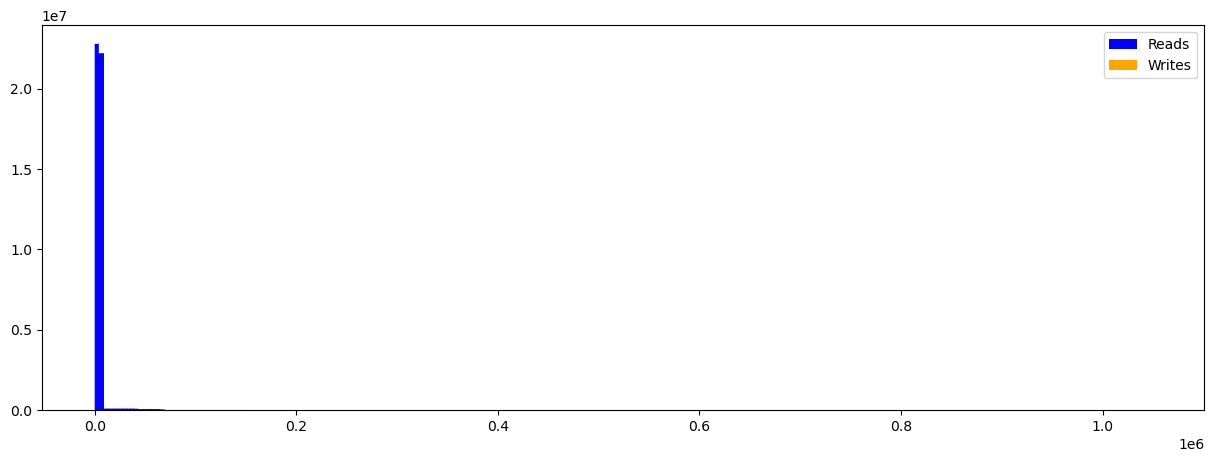

In [22]:
Graficar(Baseline_Acceses)


Gráficar

Accesos a la cache: durante el proceso de inferencia VBW

In [15]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/AlexNet_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)
##                           

ciclo de jecución de la red 

In [6]:

LI = [0,3,9,11,17,19,25,31,37,40,45,50]
AI = [2,8,10,16,18,24,30,36,38,44,49,53]
Buffer,ciclos =  buffer_simulation(AlexNet, test_dataset, integer_bits = 4, fractional_bits = 11, samples = 5, start_from = 0,
                                  bit_invertion = False, bit_shifting = False, CNN_gating = False,
                                  buffer_size = 1048576, write_mode ='default', save_results = False,
                                  results_dir = 'Data/Stats/AlexNet/Colorectal Dataset/CNN-Gated/',
                                  layer_indexes = LI , activation_indixes = AI)



buffer sections:  [0, 65536, 131072, 196608, 262144, 327680, 393216, 458752, 524288]
Simulation Started, time: 15:06:31 cycles:  0 offset:  0


CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:

In [14]:
buffer

{'Number of Addresses': 290400,
 'Data': array([0, 0, 0, ..., 0, 0, 0], dtype=int8),
 'HighCyclesCount': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 'OffCyclesCount': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 'LowCyclesCount': array([4220838, 4220838, 4220838, ..., 4220838, 4220838, 4220838],
       dtype=uint32),
 'Flips': array([0, 0, 0, ..., 0, 0, 0], dtype=uint32),
 'offset': 0}

In [19]:
#ciclos

In [15]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\AlexNet\cycles')

1406946

In [3]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\AlexNet\PE_16_150\cycles')

211041900

In [5]:
211041900/1406946

150.0

# SqueezeNet

In [13]:

word_size  = 16
afrac_size = 9
aint_size  = 6
wfrac_size = 15
wint_size  = 0

trainBatchSize = testBatchSize = 1
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (224, 224), 8, trainBatchSize, testBatchSize)


# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216
# Directorio de los pesos
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'SqueezeNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


# In[4]:


activation_aging = [True]*22


#Acá la creamos, notese que como no se introduciran fallos en activaciones no es necesario pasar locs ni masks
SqueezeNet = GetNeuralNetworkModel('SqueezeNet', (224,224,3), 8, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size, 
                                 batch_size = testBatchSize)
SqueezeNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
SqueezeNet.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
WeightQuantization(model=SqueezeNet, frac_bits=wfrac_size, int_bits=wint_size)
loss,acc =Net1.evaluate(test_dataset)

C:\Users\usuario\anaconda3\envs\env_first\lib\site-packages\tensorflow\python\data\ops\dataset_ops.py:3703: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable.debug_mode()`.
  warnings.warn(


In [18]:
#num_address= 801816

num_address  =1048576
samples      = 150
Indices = [0,3,7, 9,(13,14),20,(24,25),31,(35,36),42,44,(48,49),55,(59,60),66,(70,71),77,(81,82),88,90,(94,95),101,104]
Data    = GetReadAndWrites(SqueezeNet,Indices,num_address,samples,CNN_gating=False,network_name='SqueezeNet')
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(SqueezeNet,Indices,num_address,samples,CNN_gating=True,network_name='SqueezeNet')
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
df_writes_Read =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/SqueezeNet_reads_and_write_num_adress_total.xlsx') as writer:
       df_writes_Read.to_excel(writer, sheet_name='base', index=False)
##                           
#save_obj(Baseline_Acceses,'Data/Acceses/SqueezeNet/Baseline_v2')
#save_obj(CNN_gating_Acceses,'Data/Acceses/SqueezeNet/CNN_gating_Fix_v2')

procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150
procesados:  25
procesados:  50
procesados:  75
procesados:  100
procesados:  125
procesados:  150


NameError: name 'df_resumen_bit' is not defined

In [15]:
#Graficar(Baseline_Acceses)
Baseline_Acceses=load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\SqueezeNet\PE_16\Baseline_ya')


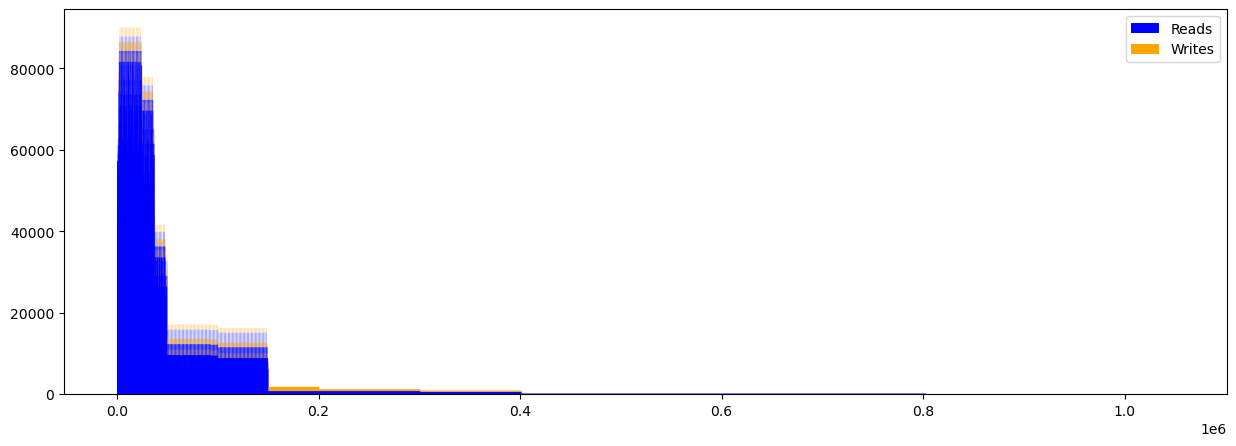

In [16]:
plt.figure(figsize=(15, 5))
plt.stackplot(Baseline_Acceses.to_dict()['index'].values(),
              Baseline_Acceses.to_dict()['Lecturas'].values(),
              Baseline_Acceses.to_dict()['Escrituras'].values(),
              colors=['blue', 'orange'])
plt.legend(['Reads','Writes'])

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/SqueezeNett_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)
##                           

ciclos

In [ ]:


LI = [0,3,7, 9,(13,14),20,(24,25),31,(35,36),42,44,(48,49),55,(59,60),66,(70,71),77,(81,82),88,90,(94,95),101,104]
AI = [2,6,8,12,     19,23,     30,34,     41,43,47,     54,58,     65,69,     76,80 ,    87,89,93,    100,103,107]
buffer_simulation(SqueezeNet,test_dataset, integer_bits = 6, fractional_bits = 9, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/SqueezeNet/Colorectal Dataset/CNN-Gated/Adjusted Buffer/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

In [13]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\SqueezeNet\PE_16\cycles')

218005350

In [2]:
218005350/150

1453369.0

# DenseNet

In [ ]:
trainBatchSize = testBatchSize = 1
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (224, 224), 8, trainBatchSize, testBatchSize)

word_size  = 16
afrac_size = 12
aint_size  = 3
wfrac_size = 13
wint_size  = 2

# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216
# Directorio de los pesos
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'DenseNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


# In[4]:


activation_aging = [True]*188

DenseNet = GetNeuralNetworkModel('DenseNet', (224,224,3), 8, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size,
                                 batch_size = testBatchSize)
DenseNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
DenseNet.compile(optimizer=optimizer, loss=loss, metrics='accuracy')

In [ ]:

num_address  =1048576
samples      = 150
Indices=[0,4,11,12,16,(22,11),25,29,(35,24),38,42,(48,37),51,55,(61,50),64,68,(74,63),77,81,(87,76),90,94,97,99,103,(109,97),
        112,116,(122,111),125,129,(135,124),138,142,(148,137),151,155,(161,150),164,168,(174,163),177,181,(187,176),
        190,194,(200,189),203,207,(213,202),216,220,(226,215),229,233,(239,228),242,246,(252,241),255,259,262,264,268,(274,262),
        277,281,(287,276),290,294,(300,289),303,307,(313,302),316,320,(326,315),329,333,(339,328),342,346,(352,341),
        355,359,(365,354),368,372,(378,367),381,385,(391,380),394,398,(404,393),407,411,(417,406),420,424,(430,419),
        433,437,(443,432),446,450,(456,445),459,463,(469,458),472,476,(482,471),485,489,(495,484),498,502,(508,497),
        511,515,(521,510),524,528,(534,523),537,541,(547,536),550,554,(560,549),563,567,(573,562),576,580,583,585,589,(595,583),
        598,602,(608,597),611,615,(621,610),624,628,(634,623),637,641,(647,636),650,654,(660,649),663,667,(673,662),
        676,680,(686,675),689,693,(699,688),702,706,(712,701),715,719,(725,714),728,732,(738,727),741,745,(751,740),
        754,758,(764,753),767,771,(777,765),780,784,(790,779),793,797,800]
Data     = GetReadAndWrites(DenseNet,Indices,num_address,samples,CNN_gating=False,network_name='DenseNet')
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data     = GetReadAndWrites(DenseNet,Indices,num_address,samples,CNN_gating=True,network_name='DenseNet')
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
df_writes_Read =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/DenseNet_reads_and_write_num_adress_total.xlsx') as writer:
        df_writes_Read.to_excel(writer, sheet_name='base', index=False)

In [ ]:
Graficar(Baseline_Acceses)

In [ ]:
Graficar(Experiment_Acceses)

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/DenseNet_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)

ciclos : analizar por qué start_fron esta en 137 correo con 0  aver que pasa

In [ ]:
LI = [0,4,11,12,16,     22,25,29,     35,38,42,     48,51,55,     61,64,68,     74,77,81,     87,90,94,97,99,103,      109,
     112,116,      122,125,129,      135,138,142,      148,151,155,      161,164,168,      174,177,181,      187,
     190,194,      200,203,207,      213,216,220,      226,229,233,      239,242,246,      252,255,259,262,264,268,      274,
     277,281,      287,290,294,      300,303,307,      313,316,320,      326,329,333,      339,342,346,      352,
     355,359,      365,368,372,      378,381,385,      391,394,398,      404,407,411,      417,420,424,      430,
     433,437,      443,446,450,      456,459,463,      469,472,476,      482,485,489,      495,498,502,      508,
     511,515,      521,524,528,      534,537,541,      547,550,554,      560,563,567,      573,576,580,583,585,589,      595,
     598,602,      608,611,615,      621,624,628,      634,637,641,      647,650,654,      660,663,667,      673,
     676,680,      686,689,693,      699,702,706,      712,715,719,      725,728,732,      738,741,745,      751,
     754,758,      764,767,771,      777,780,784,      790,793,797,800]
AI = [2,9,11,15,21,(23,11),28,34,(36,24),41,47,(49,37),54,60,(62,50),67,73,(75,63),80,86,(88,76),93,96,98,102,108,(110,98),
     115,121,(123,111),128,134,(136,124),141,147,(149,137),154,160,(162,150),167,173,(175,163),180,186,(188,176),
     193,199,(201,189),206,212,(214,202),219,225,(227,215),232,238,(240,228),245,251,(253,241),258,261,263,267,273,(275,263),
     280,286,(288,276),293,299,(301,289),306,312,(314,302),319,325,(327,315),332,338,(340,328),345,351,(353,341),
     358,364,(366,353),371,377,(379,367),384,390,(392,380),397,403,(405,393),410,416,(418,406),423,429,(431,419),
     436,442,(444,432),449,455,(457,445),462,468,(470,458),475,481,(483,471),488,494,(496,484),501,507,(509,497),
     514,520,(522,510),527,533,(535,523),540,546,(548,536),553,559,(561,549),566,572,(574,562),579,582,584,588,594,(596,584),
     601,607,(609,597),614,620,(622,610),627,633,(635,623),640,646,(648,636),653,659,(661,649),666,672,(674,662),
     679,685,(687,675),692,698,(700,688),705,711,(713,701),718,724,(726,714),731,737,(739,727),744,750,(752,740),
     757,763,(765,753),770,776,(778,766),783,789,(791,779),796,799,803]
Buffer,ciclos = buffer_simulation(DenseNet,test_dataset, integer_bits = 3, fractional_bits = 12, samples = 150, start_from = 137,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/DenseNet/Colorectal Dataset/CNN-Gated/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

In [10]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\DenseNet\PE_16_1imag\cycles')

6937351

# MobileNet

In [ ]:
trainBatchSize = testBatchSize = 1
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (224, 224), 8, trainBatchSize, testBatchSize)


# In[3]:


# Numero de bits para activaciones (a) y pesos (w)
word_size  = 16
afrac_size = 11
aint_size  = 4
wfrac_size = 14
wint_size  = 1

# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216
# Directorio de los pesos
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'MobileNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


# In[4]:





In [ ]:
activation_aging = [True]*29
MobileNet = GetNeuralNetworkModel('MobileNet', (224,224,3), 8, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size,  batch_size = testBatchSize)
MobileNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
MobileNet.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
WeightQuantization(model=MobileNet, frac_bits=wfrac_size, int_bits=wint_size)
loss,acc  = MobileNet.evaluate(test_dataset)

In [ ]:
num_address  =1048576
samples      = 150
Indices = [0,4,10,16,23,29,35,41,48,54,60,66,73,79,85,91,97,103,109,115,121,127,133,139,146,152,158,164,170,175]
Data    = GetReadAndWrites(MobileNet,Indices,num_address,sample,CNN_gating=False)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(MobileNet,Indices,num_address,samples,CNN_gating=True)
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
df_writes_Read =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/MobileNet_reads_and_write_num_adress_total.xlsx') as writer:
        df_writes_Read.to_excel(writer, sheet_name='base', index=False)

In [ ]:
Graficar(Baseline_Acceses)

In [ ]:
Graficar(Experiment_Acceses)

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/MobileNet_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)

ciclos analizar start_from = 128

In [ ]:
LI = [0,4,10,16,23,29,35,41,48,54,60,66,73,79,85,91,97,103,109,115,121,127,133,139,146,152,158,164,170,175]
AI = [2,9,15,21,28,34,40,46,53,59,65,71,78,84,90,96,102,108,114,120,126,132,138,144,151,157,163,169,173,179]
buffer_simulation(MobileNet,test_dataset, integer_bits = 4, fractional_bits = 11, samples = 150, start_from = 128,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/MobileNet/Colorectal Dataset/CNN-Gated/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

In [11]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\mobileNet\PE_16_1_imag\cycles')

1670088

# VGG16

In [ ]:
trainBatchSize = testBatchSize = 1
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (224, 224), 8, trainBatchSize, testBatchSize)


# In[3]:



word_size  = 16
afrac_size = 12
aint_size  = 3
wfrac_size = 15
wint_size  = 0

# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216
# Directorio de los pesos
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'VGG16')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


# In[4]:


activation_aging = [True]*21

VGG16 = GetNeuralNetworkModel('VGG16', (224,224,3), 8, faulty_addresses=locs, masked_faults=error_mask,aging_active=activation_aging, word_size=word_size, frac_size=afrac_size, 
                                 batch_size = testBatchSize)
VGG16.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
VGG16.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
WeightQuantization(model=VGG16, frac_bits=wfrac_size, int_bits=wint_size)
loss,acc  = VGG16.evaluate(test_dataset)

In [ ]:
num_address  =1048576
samples      = 150
#num_address=802816
Indices = [0,3,7,11,13,17,21,23,27,31,35,37,41,45,49,51,55,59,63,66,70,74]
Data    = GetReadAndWrites(VGG16,Indices,num_address,samples,CNN_gating=False)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(VGG16,Indices,num_address,samples,CNN_gating=True)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)

df_resumen_bit =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_resumen_bit.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
#print(df_resumen_bit)
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/VGG16_reads_and_write_num_adress_tota.xlsx') as writer:
        df_resumen_bit.to_excel(writer, sheet_name='base', index=False)

In [ ]:
Graficar(Baseline_Acceses)

In [ ]:
Graficar(Experiment_Acceses)

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/VGG16_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)

In [ ]:
LI = [0,3,7,11,13,17,21,23,27,31,35,37,41,45,49,51,55,59,63,66,70,74]
AI = [2,6,10,12,16,20,22,26,30,34,36,40,44,48,50,54,58,62,64,69,73,77]
buffer_simulation(VGG16,test_dataset, integer_bits = 3, fractional_bits = 12, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/VGG16/Colorectal Dataset/CNN-Gated/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

In [13]:
load_obj('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\ciclos\VGG16\PE_16_1_imag\cycles')

27160746

# ZFNet

In [ ]:
trainBatchSize = testBatchSize = 1
_, _, test_dataset = GetDatasets('colorectal_histology', (80, 5, 15), (224, 224), 8, trainBatchSize, testBatchSize)



word_size  = 16
afrac_size = 11
aint_size  = 4
wfrac_size = 14
wint_size  = 1

# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216

cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'ZFNet')
wgt_dir = os.path.join(wgt_dir, 'Colorectal Dataset')
wgt_dir = os.path.join(wgt_dir,'Weights')


# In[4]:


activation_aging = [True]*11

ZFNet = GetNeuralNetworkModel('ZFNet', (224,224,3), 8, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size, 
                                 batch_size = testBatchSize)
ZFNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
ZFNet.compile(optimizer=optimizer, loss=loss, metrics='accuracy')
WeightQuantization(model=ZFNet, frac_bits=wfrac_size, int_bits=wint_size)
loss,acc  = Net2.evaluate(test_dataset)

In [ ]:
num_address  =1048576
samples      = 150
Indices = [0,3,7,11,15,19,23,27,31,34,37,40]
Data    = GetReadAndWrites(ZFNet,Indices,num_address,samples,CNN_gating=False)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data    = GetReadAndWrites(ZFNet,Indices,num_address,samples,CNN_gating=True)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
df_writes_Readt =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
#print(df_resumen_bit)
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/ZFNet_reads_and_write_num_adress_tota.xlsx') as writer:
        df_writes_Read.to_excel(writer, sheet_name='base', index=False)

In [ ]:
Graficar(Baseline_Acceses)

In [ ]:
Graficar(Experiment_Acceses)

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/VGG16_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)

ciclos

In [ ]:
LI = [0,3,7 ,11,15,19,23,27,31,34,37,40]
AI = [2,6,10,14,18,22,26,30,32,36,39,43]
buffer_simulation(ZFNett,testSet, integer_bits = 4, fractional_bits = 11, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/ZFNet/Colorectal Dataset/Baseline/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

# PiloNet

In [ ]:
trainBatchSize = testBatchSize = 1
_,_,test_dataset = GetPilotNetDataset(csv_dir='Data/Datos/driving_log.csv', train_batch_size=1, test_batch_size=1)



word_size  = 16
afrac_size = 15  
aint_size  = 0
wfrac_size = 15
wint_size  = 0

# Tamaño del buffer de activaciones == al tamaño de la capa con mayor numero de activaciones (290400 pesos de 16 bits cada uno)
#abuffer_size = 16777216
# Directorio de los pesos
cwd = os.getcwd()
wgt_dir = os.path.join(cwd, 'Data')
wgt_dir = os.path.join(wgt_dir, 'Trained Weights')
wgt_dir = os.path.join(wgt_dir, 'PilotNet')
wgt_dir = os.path.join(wgt_dir,'Weights')



# In[4]:


activation_aging = [True]*10

PilotNet = GetNeuralNetworkModel('PilotNet', (160,320,3), 1, faulty_addresses=locs, masked_faults=error_mask,
                                 aging_active=activation_aging, word_size=word_size, frac_size=afrac_size, 
                                 batch_size = testBatchSize)
PilotNet.load_weights(wgt_dir).expect_partial()
loss = tf.keras.losses.CategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
PilotNet.compile(optimizer=optimizer, loss='mse')
WeightQuantization(model=PilotNet, frac_bits=wfrac_size, int_bits=wint_size)
loss  = PilotNet.evaluate(test_dataset)


In [ ]:
num_address  =1048576
samples      = 150
Indices = [5,6,10,14,18,22,28,32,36,40,44]
Data    = GetReadAndWrites(PilotNet,Indices,num_address,samples,CNN_gating=False)
stats   = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Baseline_Acceses   = pd.DataFrame(stats).reset_index(drop=False)
Data   = GetReadAndWrites(PilotNet,Indices,num_address,samples,CNN_gating=True)
stats    = {'Lecturas': Data['Reads'],'Escrituras': Data['Writes']}
Experiment_Acceses = pd.DataFrame(stats).reset_index(drop=False)
df_writes_Read =  pd.concat([Baseline_Acceses,Experiment_Acceses], axis=1, join='outer')
df_writes_Read.columns = ['index','Lecturas','Escrituras','index','Lecturas','Escrituras']
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/PilotNet_reads_and_write_num_adress_tota.xlsx') as writer:
        df_writes_Read.to_excel(writer, sheet_name='base', index=False)

In [ ]:
Graficar(Baseline_Acceses)

In [ ]:
Graficar(Experiment_Acceses)

In [ ]:
VBW=[101102, 124520, 302065, 331634, 340492, 340493, 360087, 360088, 377722, 377723, 419841, 458633, 458634, 465007, 465008, 465034, 465197, 465389, 544769, 544770, 545758, 590341, 590402, 590403, 590404, 590405, 590406, 590407, 590408, 590409, 590424, 590610, 590706, 590707, 590790, 590804, 611329]  # Tamaño del buffer, igual a la capa mas grande de la red (este caso), o un tamaño fijo pre-establecido.
writes_Read_VBW=df_writes_Read.iloc[VBW]
with pd.ExcelWriter('Analizando_fichero_detalle/Alterado_fichero/Lectura_escritura_buffer/PilotNet_reads_and_write_VBW.xlsx') as writer:
        writes_Read_VBW.to_excel(writer, sheet_name='base', index=False)

Ciclos

In [ ]:
LI = [5,6,10,14,18,22,28,32,36,40,44]
AI = [5,9,13,17,21,25,31,35,39,43,45]
buffer_simulation(PilotNet,testSet, integer_bits = 0, fractional_bits = 15, samples = 150, start_from = 0,
                 bit_invertion = False, bit_shifting = False, CNN_gating = False, write_mode ='default',
                 results_dir = 'Data/Stats/PilotNet/Steering Regression/Baseline/', buffer_size = num_address,
                 layer_indexes = LI , activation_indixes = AI)

# Gráficos 

In [ ]:
# Lineas de los gráficos solo horizontales y a 0.5
#Los colores siempre los mismos para cada red(colocarlos los valores en variables)

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn import preprocessing
import matplotlib.ticker as ticker
from pylab import *
from IPython.display import display,HTML
import cufflinks as cf
import plotly.offline as py
l='0.5'
marksize=4



datos  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC')
ECC= datos.set_index("Voltajes")

ECC  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC', usecols=["Acc_Sque" ])/0.930667 
#df= df.dropna()
Baseline=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='Baseline', usecols=["Acc_Sque"])/0.930667


ECC_VGG  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC', usecols=["Acc_VGG16" ])/0.805333316326141
#df= df.dropna()
Baseline_VGG=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='Baseline', usecols=["Acc_VGG16"])/0.805333316326141

ECC_FZNet  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC', usecols=["Acc_ZFNet" ])/0.833333313465118
#df= df.dropna()
Baseline_FZNet =pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='Baseline', usecols=["Acc_ZFNet"])/0.833333313465118

ECC_ResNet  = pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='ECC', usecols=["Acc_ResNet" ])/0.8119999
#df= df.dropna()
Baseline_ResNet =pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/acc_exp_todos_voltajes_y_redes.xlsx',sheet_name='Baseline', usecols=["Acc_ResNet"])/0.8119999465118


C:\Users\usuario\AppData\Local\Temp\ipykernel_13484\150984056.py:40: UserWarning:

FixedFormatter should only be used together with FixedLocator



<function matplotlib.pyplot.show(close=None, block=None)>

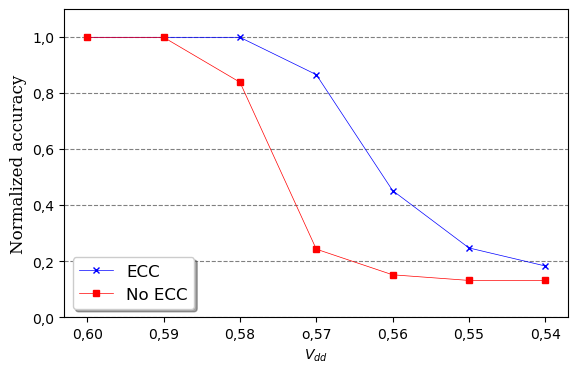

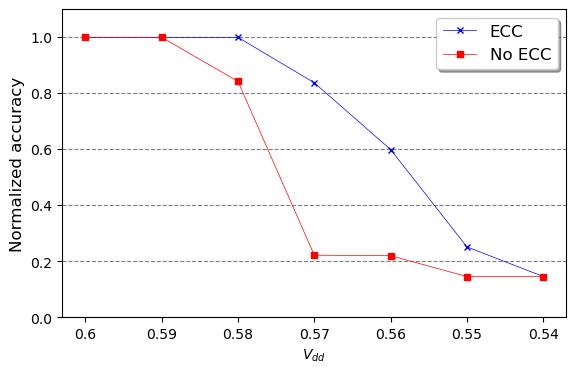

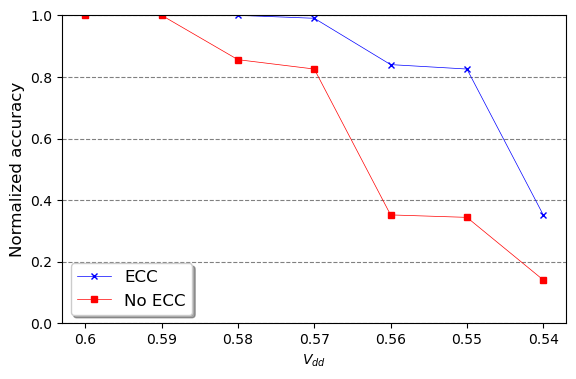

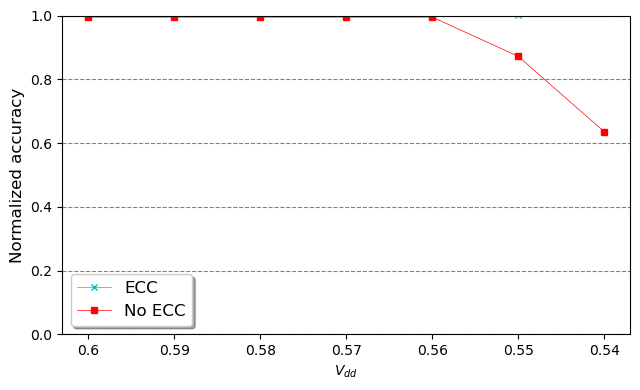

In [18]:
    from matplotlib.backends.backend_pdf import PdfPages, PdfFile

x=datos["Voltajes"]
x_esp =['0,54','0,55','0,56','o,57','0,58','0,59','0,60']
#fig = plt.figure(figsize=(6.5,3), dpi=100)
#figsize=(6.5,3)

fig1, ax1 = plt.subplots(figsize=(6.5,4))
#ax1= fig.add_subplot(1,3,1)
x_values = range(len(x))
#plt.xlabel('Vdd', fontsize=12)
plt.ylabel('Normalized accuracy', fontsize=12,fontfamily="serif")
plt.xticks(x_values, x_esp)

fig2, ax2 = plt.subplots(figsize=(6.5,4))
#ax2= fig.add_subplot(1,3,2)
x_values = range(len(x))
#plt.xlabel('Vdd',fontsize=12)
plt.ylabel('Normalized accuracy', fontsize=12)
plt.xticks(x_values, x)

fig3, ax3 = plt.subplots(figsize=(6.5,4))
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
#plt.xlabel('Vdd', fontsize=12)
plt.ylabel('Normalized accuracy', fontsize=12)

fig4, ax4 = plt.subplots(figsize=(6.5,4))
#ax3= fig.add_subplot(1,3,3)
x_values = range(len(x))
plt.xticks(x_values, x)
#plt.xlabel('Vdd', fontsize=12)
plt.ylabel('Normalized accuracy', fontsize=12)

ax1.set_ylim(0,1.1)
#ax1.set_title(" ECC vs Baseline SqueezeNet")
ax1.invert_xaxis()
ax1.set(xlabel=r'$V_{dd}$')
ax1.set_yticklabels(['0,0', '0,2', '0,4', '0,6','0,8','1,0'])

plt.ylabel('Normalized accuracy', fontsize=12)
ax2.set_ylim(0,1.1)
#ax2.set_title(" ECC vs Baseline VGG16")
ax2.invert_xaxis()
ax2.set(xlabel=r'$V_{dd}$')
#
plt.ylabel('Normalized accuracy', fontsize=12)
ax3.set_ylim(0,1)
#ax3.set_title(" ECC vs Baseline ZFNet")
ax3.invert_xaxis()
ax3.set(xlabel=r'$V_{dd}$')

ax4.set_ylim(0,1)
#ax3.set_title(" ECC vs Baseline ZFNet")
ax4.invert_xaxis()
ax4.set(xlabel=r'$V_{dd}$')

ax1.plot(ECC["Acc_Sque"], label='ECC', color='b', ls='-', lw=l, marker='x', markersize=marksize, zorder=2)
#ax1.plot(df["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(Baseline["Acc_Sque"], label='No ECC', color="r", ls='-', lw=l, marker='s', markersize=marksize)
ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=12, loc ="lower left", shadow = True)



ax2.plot(ECC_VGG["Acc_VGG16"], label='ECC', color='b', ls='-', lw=l, marker='x', markersize=marksize)
##ax2.plot(df["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax2.plot(Baseline_VGG["Acc_VGG16"], label='No ECC', color="r", ls='-', lw=l, marker='s', markersize=marksize)
ax2.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax2.legend(fontsize=12, loc ="upper right", shadow = True)
#
#

ax3.plot(ECC_FZNet["Acc_ZFNet"],label='ECC', color='b', ls='-', lw=l, marker='x', markersize=marksize)
##ax3.plot(df["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax3.plot(Baseline_FZNet["Acc_ZFNet"], label='No ECC', color="r", ls='-', lw=l, marker='s', markersize=marksize)
ax3.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax3.legend(fontsize=12, loc ="lower left", shadow = True)

ax4.plot(ECC_ResNet["Acc_ResNet"],label='ECC', color='c', ls='-', lw=l, marker='x', markersize=marksize)
##ax3.plot(df["Normalize"],  color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax4.plot(Baseline_ResNet["Acc_ResNet"], label='No ECC', color="r", ls='-', lw=l, marker='s', markersize=marksize)
ax4.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax4.legend(fontsize=12, loc ="lower left", shadow = True)

pdfFile=PdfPages("ECC vs Baseline SqueezeNet.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
#pdfFile=PdfPages("ECC vs Baseline VGG16.pdf")
#pdfFile.savefig(fig2,transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()
pdfFile=PdfPages("ECC vs Baseline ZFNet.pdf")
pdfFile.savefig(fig3, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()

plt.tight_layout()



plt.show


In [ ]:
# Generar graficos: cantidad de fallos x bits (acumulado)

In [13]:
fallos_xbits =pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/cantidad_fallos_xbits.xlsx',sheet_name='fallosxbits')
bits= fallos_xbits.set_index("bits")
fail_xbits=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/cantidad_fallos_xbits.xlsx',sheet_name='fallosxbits', usecols=["Acum_Base","Acum_Volt" ])/10360


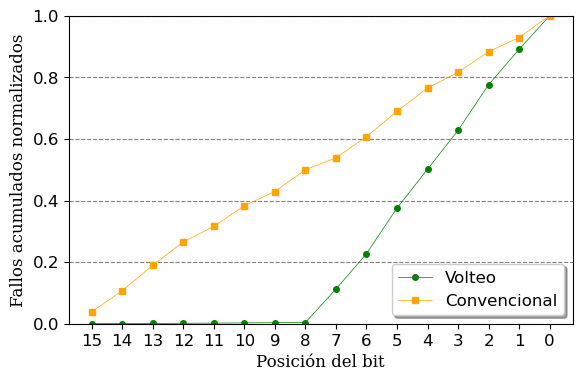

In [17]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
l='0.5'
marksize=4
x=fallos_xbits["bits"]

plt.rcParams.update({'font.size': 12})
fig1, ax1 = plt.subplots(figsize=(6.5,4))

x_values = range(len(x))

plt.xlabel('Posición del bit', fontsize=12,  fontfamily="serif")
plt.ylabel('Fallos acumulados normalizados', fontsize=12, fontfamily="serif")
plt.xticks(x_values, x)


ax1.set_ylim(0,1)
#ax1.set_title(" Accumulated bit errors")

ax1.plot(fail_xbits["Acum_Volt"], label='Volteo', color='g', ls='-', lw=l, marker='o', markersize=marksize, zorder=2)
#ax1.plot(df["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
ax1.plot(fail_xbits["Acum_Base"], label='Convencional', color="orange", ls='-', lw=l, marker='s', markersize=marksize, zorder=2)
ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=12, loc ="lower right", shadow = True)

plt.savefig('Errores_bit_acumulados.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile=PdfPages("Accumulated_bit_errors.pdf")
#pdfFile=PdfPages("Errores_bit_acumulados.pdf")
#pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()





In [4]:
errores_voltaje =pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/acc_low_and_high_VBW_error.xlsx',sheet_name='Hoja2', usecols=["Voltajes","Errores" ])
errores_voltaje_= errores_voltaje.set_index("Voltajes")
errores_voltaje_

,Errores
Voltajes,
0.54,13204
0.55,4124
0.56,1570
0.57,426
0.58,90
0.59,18
0.60,2


[Text(0.5, 0, '$V_{dd}$')]

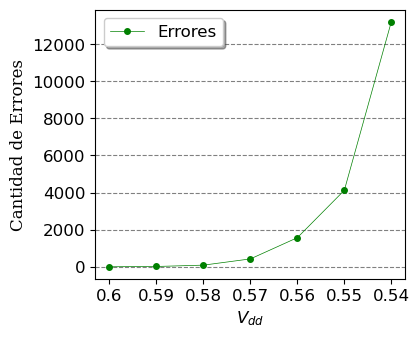

In [18]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
l='0.5'
marksize=4
x=errores_voltaje["Voltajes"]


fig1, ax1 = plt.subplots(figsize=(4,3.5))

x_values = range(len(x))

plt.xlabel('Voltajes', fontsize=12,  fontfamily="serif")
plt.ylabel('Cantidad de Errores', fontsize=12, fontfamily="serif")
plt.xticks(x_values, x)


#ax1.set_ylim(0,1)
#ax1.set_title(" Accumulated bit errors")

ax1.plot(errores_voltaje["Errores"], label='Errores', color='g', ls='-', lw=l, marker='o', markersize=marksize, zorder=2)
#ax1.plot(df["Normalize"], color='dimgray', ls='-', lw='2', marker='D', markersize='6')
#ax1.plot(fail_xbits["Acum_Base"], label='Conventional', color="orange", ls='-', lw=l, marker='s', markersize=marksize, zorder=2)
ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=12, loc ="best", shadow = True)
ax1.invert_xaxis()
ax1.set(xlabel=r'$V_{dd}$')






In [11]:
acc_correc_bits=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/cantidad_fallos_xbits.xlsx',sheet_name='acc_correct_bit_to_bit', usecols=["bits","Acc_Alex","Acc_Sque", "Acc_Dense" , "Acc_Mobile","Acc_VGG16", "Acc_ZFNet"])
bits= acc_correc_bits.set_index("bits")

In [12]:
bits

,Acc_Alex,Acc_Sque,Acc_Dense,Acc_Mobile,Acc_VGG16,Acc_ZFNet
bits,,,,,,
15,0.446667,0.122667,0.668000,0.122667,0.117333,0.117333
14,0.713333,0.122667,0.892000,0.202667,0.117333,0.122667
13,0.864000,0.122667,0.917333,0.425333,0.174667,0.452000
12,0.889333,0.126667,0.917333,0.685333,0.257333,0.620000
11,0.892000,0.374667,0.914667,0.729333,0.544000,0.704000
10,0.892000,0.722667,0.917333,0.873333,0.788000,0.822667
9,0.890667,0.888000,0.917333,0.874667,0.798667,0.830667
8,0.890667,0.928000,0.916000,0.880000,0.804000,0.830667
7,0.890667,0.932000,0.916000,0.878667,0.806667,0.829333


<Figure size 2000x500 with 0 Axes>

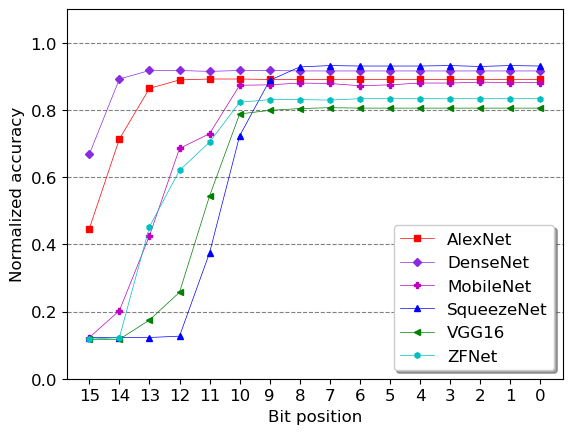

In [13]:
from matplotlib.backends.backend_pdf import PdfPages, PdfFile

l='0.5'
marksize=4

x=acc_correc_bits["bits"]
fig = plt.figure(figsize=(20,5), dpi=100)
plt.rcParams.update({'font.size': 12})
fig1, ax1 = plt.subplots()

x_values = range(len(x))

plt.xlabel('Bit position', fontsize=12)
plt.ylabel('Normalized accuracy', fontsize=12)
plt.xticks(x_values, x)


ax1.set_ylim(0,1.1)
#ax1.set_title("  bit ")

ax1.plot(acc_correc_bits["Acc_Alex"], label='AlexNet', color='r', ls='-', lw=l, marker='s', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Dense"], label='DenseNet', color="blueviolet", ls='-', lw=l, marker='D', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Mobile"], label='MobileNet', color="m", ls='-', lw=l, marker='P', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Sque"], label='SqueezeNet', color="b", ls='-', lw=l, marker='^', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_VGG16"], label='VGG16', color="g", ls='-', lw=l, marker='<', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_ZFNet"], label='ZFNet', color="c", ls='-', lw=l, marker='h', markersize=marksize)
ax1.grid(axis='y', color = 'gray', linestyle = 'dashed')
ax1.legend(fontsize=12, loc ="lower right", shadow = True)

pdfFile=PdfPages("Correction bit_to_bit_new.pdf")
pdfFile.savefig(fig1, transparent = True, bbox_inches = 'tight', pad_inches = 0)
pdfFile.close()
#



In [17]:
import pandas as pd
acc_low_and_high_VBW_error=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/acc_low_and_high_VBW_error.xlsx',sheet_name='graficar_english',usecols=["Mask", "L&HO","HO","LO","HOmob"] )
acc_low_and_high_VBW_error= acc_low_and_high_VBW_error.set_index("Mask")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [18]:
acc_low_and_high_VBW_error

,LO,L&HO,HO,HOmob
Mask,,,,
Alex,1.000000,1.000000,0.500000,0.836826
Dense,1.002956,1.001496,0.722654,0.997117
Mobile,0.996974,0.993949,0.142209,0.620272
ResNet,1.000000,1.000000,0.645320,1.000000
Squeeze,0.997135,0.471347,0.131805,0.197708
VGG,0.998344,0.632450,0.145695,0.145695
ZF,0.996800,0.848000,0.140800,0.377600
Avg,0.998887,0.849606,0.346926,0.596460


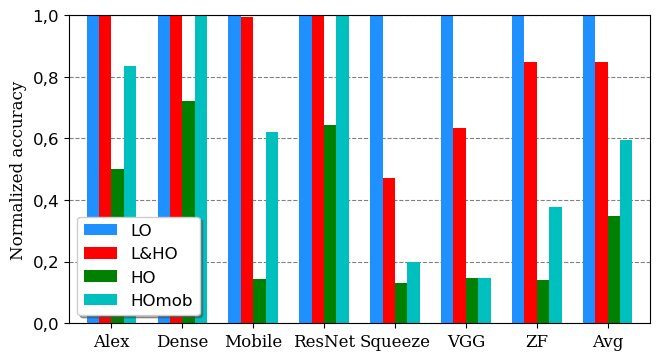

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(acc_low_and_high_VBW_error.index)
acc=['0,0', '0,2', '0,4', '0,6','0,8','1,0']
#fig1, ax1 = plt.subplots(figsize=(6.5,4))
 
x = np.arange(n)
y = np.linspace(0,1,6)
#coloresRedes = ['bisque', 'orange','darkorange','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','red', 'green','c']
#fig = plt.figure(figsize=(10,5), dpi=100)
#plt.yticks([y,acc])

#ax1.plot(acc_low_and_high_VBW_error,kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2)
acc_low_and_high_VBW_error.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(7.5,4), zorder=2)
#plt.legend(  fontsize=12,loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1)
#plt.yticks('')
plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.ylabel('Normalized accuracy', fontsize=12, fontfamily="serif")
plt.xticks(x, acc_low_and_high_VBW_error.index, fontsize= 12, fontfamily="serif" )
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
#plt.xlabel('', fontsize=12)
plt.xlabel('', fontsize=12)
plt.legend(fontsize=12, loc ="lower left", shadow = True)
plt.savefig('acc_error_LO_HO_VBW_HO_more_one_bit.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.savefig('acc_error_PB_PA_VBW_.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
#plt.show()



In [ ]:
import pandas as pd
acc_low_and_high_VBW_error=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/High_order_greater_2.xlsx',sheet_name='fichero_707',usecols=["Mask", "PB&A","PA","PB"] )
acc_low_and_high_VBW_error= acc_low_and_high_VBW_error.set_index("Mask")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(acc_low_and_high_VBW_error.index)
acc=['0,0', '0,2', '0,4', '0,6','0,8','1,0']
#fig1, ax1 = plt.subplots(figsize=(6.5,4))
 
x = np.arange(n)
y = np.linspace(0,1,6)
#coloresRedes = ['bisque', 'orange','darkorange','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','red', 'green']
#fig = plt.figure(figsize=(10,5), dpi=100)
#plt.yticks([y,acc])

#ax1.plot(acc_low_and_high_VBW_error,kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2)
acc_low_and_high_VBW_error.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(7.5,4), zorder=2);plt.legend(  fontsize=12,loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1)
#plt.yticks('')
plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.ylabel('Normalized accuracy', fontsize=12, fontfamily="serif")
plt.xticks(x, acc_low_and_high_VBW_error.index, fontsize= 12, fontfamily="serif" )
#plt.yticks(np.arange(6), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
#plt.xlabel('', fontsize=12)
plt.xlabel('', fontsize=12)

plt.savefig('acc_error_PB_PA_VBW.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()


In [99]:
import pandas as pd
anais_Tipos_errores=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/gráficos/acc_low_and_high_VBW_error.xlsx',sheet_name='errores',usecols=["Estructura", "Cantidad"] )
anais_Tipos_errores= anais_Tipos_errores.set_index("Estructura")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])
anais_Tipos_errores

,Cantidad
Estructura,
Parte Baja,4701
Parte Alta,4701
Parte B&A,37


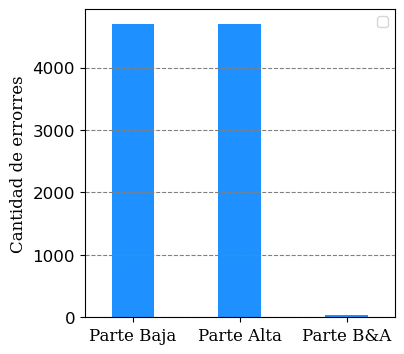

In [100]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(anais_Tipos_errores.index)
nombres=[ "Tipos_errores","Cantidad"]
 
x = np.arange(n)
#coloresRedes = ['bisque', 'orange','darkorange','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','red','darkorange']
#fig = plt.figure(figsize=(10,5), dpi=100)

anais_Tipos_errores.plot(kind ='bar' ,width = 0.40, fontsize=12,figsize=(4,4), color = coloresRedes )
#plt.pie(anais_Tipos_errores, labels=nombres)
plt.ylabel('Cantidad de errorres', fontsize=12, fontfamily="serif")
plt.xticks(x, anais_Tipos_errores.index, fontsize= 12, fontfamily="serif" )
plt.legend('')

plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
plt.xlabel('', fontsize=12)

#xlabel('')

#plt.savefig('acc_low_and_high_VBW_error.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()


### Máscra base

In [65]:
import pandas as pd
Resumen_x2_x3_4_esp=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_base_esp',usecols=["redes","Base","I-A ECC", "ECC","Volteo","V + R"] )
Resumen_x2_x3_4_es= Resumen_x2_x3_4_esp.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [66]:
Resumen_x2_x3_4_es

,Base,I-A ECC,ECC,Volteo,V + R
redes,,,,,
Alex,0.499981,0.582314,0.836795,0.999963,0.999963
Dense,0.722654,0.779591,0.997117,1.001496,1.002956
Mobile,0.141892,0.141892,0.608325,0.996264,0.990226
Squeeze,0.131800,0.131800,0.183375,0.792235,0.989936
VGG,0.145701,0.145701,0.145701,0.771555,0.996730
ZF,0.140806,0.140806,0.352014,0.846434,0.996840
Avg,0.297139,0.320351,0.520554,0.901325,0.996108


<Figure size 2000x500 with 0 Axes>

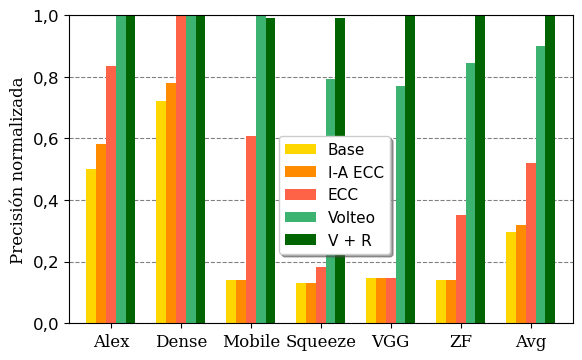

In [67]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_x2_x3_4_es.index)

 
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_x2_x3_4_es.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2 );
#plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.55), shadow = True)
plt.legend(  fontsize=11, bbox_to_anchor=(0.653,0.2),shadow = True)
plt.ylim(0,1.0)
plt.ylabel('Precisión normalizada', fontsize=12, fontfamily="serif")
plt.xlabel('')
plt.xticks(x, Resumen_x2_x3_4_es.index, fontsize= 12, fontfamily="serif")
plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
plt.savefig('Resumen_acc_experimentos.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#


In [24]:
import pandas as pd
Resumen_x2_x3_4=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_base',usecols=["redes","Base","I-A ECC", "ECC","Flip","F+P"] )
Resumen_x2_x3_4= Resumen_x2_x3_4.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


<Figure size 2000x500 with 0 Axes>

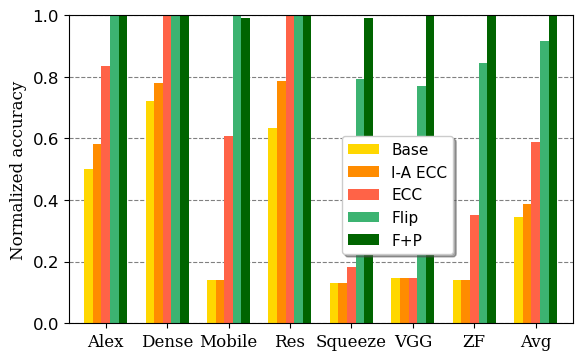

In [25]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_x2_x3_4.index)

 
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_x2_x3_4.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2 );
#plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.55), shadow = True)
plt.legend(  fontsize=11, bbox_to_anchor=(0.653,0.2),shadow = True)
plt.ylim(0,1.0)
plt.ylabel('Normalized accuracy', fontsize=12, fontfamily="serif")
plt.xlabel('')
plt.xticks(x, Resumen_x2_x3_4.index, fontsize= 12, fontfamily="serif")
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
plt.savefig('summary_acc_experiments.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()


### Máscra basex2

In [28]:
import pandas as pd
Resumen_x2_x3_4=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_basex2',usecols=["redes","Baseline","Iso-area ECC",  "ECC","Flip","Flip+Patch"] )
Resumen_base_x2= Resumen_x2_x3_4.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [29]:
Resumen_base_x2

,Baseline,Iso-area ECC,ECC,Flip,Flip+Patch
redes,,,,,
Alex,0.348802,0.365269,0.729042,1.001497,1.001497
Dense,0.427753,0.458411,0.947480,1.000037,1.004416
Mobile,0.139183,0.139183,0.189107,0.954614,0.995461
Squeeze,0.131805,0.131805,0.131805,0.588825,0.954155
VGG,0.145695,0.145695,0.145695,0.649007,0.993378
ZF,0.140800,0.140800,0.190400,0.852800,0.996800
Avg,0.222340,0.230194,0.388922,0.841130,0.990951


<Figure size 2000x500 with 0 Axes>

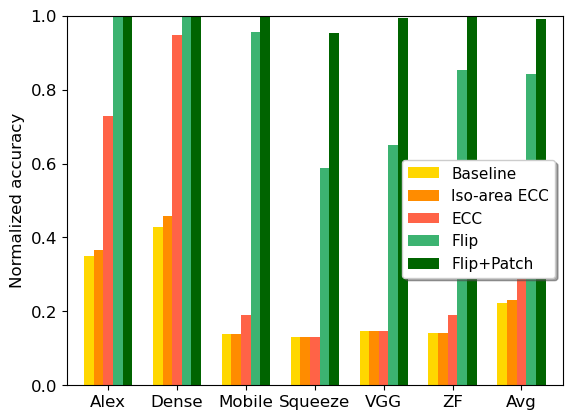

In [93]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_base_x2.index)

 
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_base_x2.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1)
plt.ylabel('Normalized accuracy', fontsize=12)
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, Resumen_base_x2.index, fontsize= 12)
plt.xticks(rotation = 0)

plt.savefig('Resumen_acc_exp_base_x2.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#


### Máscra basex3

In [2]:
import pandas as pd
Resumen_x2_x3_4=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_basex3',usecols=["redes","Baseline","Iso-area ECC",  "ECC","Flip","Flip+Patch"] )
Resumen_base_x3= Resumen_x2_x3_4.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [3]:
Resumen_base_x3

,Baseline,Iso-area ECC,ECC,Flip,Flip+Patch
redes,,,,,
Alex,0.285928,0.297904,0.585329,1.000000,1.001497
Dense,0.262783,0.322640,0.727034,0.997117,1.004416
Mobile,0.139183,0.139183,0.139183,0.845688,0.987897
Squeeze,0.131805,0.131805,0.131805,0.383954,0.808023
VGG,0.145695,0.145695,0.145695,0.485099,0.978477
ZF,0.140800,0.140800,0.140800,0.856000,1.006400
Avg,0.184366,0.196338,0.311641,0.761310,0.964452


<Figure size 2000x500 with 0 Axes>

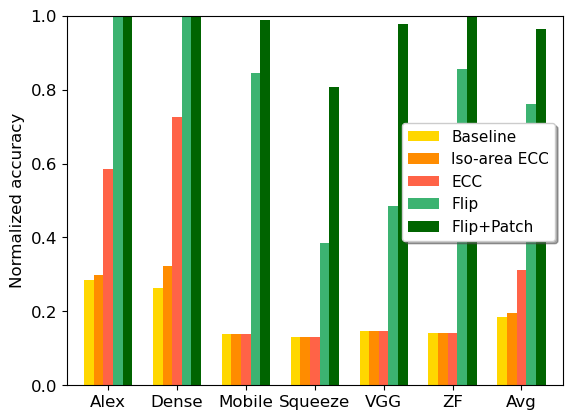

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_base_x3.index)

 
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_base_x3.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
#plt.legend(  fontsize=12,loc ="center right",bbox_to_anchor=(0.70,0.50), shadow = True)
plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.55) ,shadow = True)
plt.ylim(0,1)
plt.ylabel('Normalized accuracy', fontsize=12)
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, Resumen_base_x3.index, fontsize= 12)
plt.xticks(rotation = 0)

plt.savefig('Resumen_acc_exp_base_x3.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#


### Máscra basex4

In [4]:
import pandas as pd
Resumen_x2_x3_4=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='graf_basex4',usecols=["redes","Base","I-A ECC",  "ECC","Flip","F+P"] )
Resumen_base_x4= Resumen_x2_x3_4.set_index("redes")
#Resumen=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Resumen_x2_x3_4.xlsx',sheet_name='base', usecols=["redes","Original","Base", "base_Volt", "ECC","1bytex","ECC_base_x4"])


In [5]:
Resumen_base_x4

,Base,I-A ECC,ECC,Flip,F+P
redes,,,,,
Alex,0.245509,0.248503,0.435629,0.998503,1.002994
Dense,0.140151,0.197087,0.611701,0.998577,1.004416
Mobile,0.139183,0.139183,0.139183,0.851740,0.989410
Squeeze,0.131805,0.131805,0.131805,0.283668,0.727794
VGG,0.145695,0.145695,0.145695,0.377483,0.965232
ZF,0.140800,0.140800,0.140800,0.852800,1.004800
Avg,0.157191,0.167179,0.267469,0.727128,0.949108


<Figure size 2000x500 with 0 Axes>

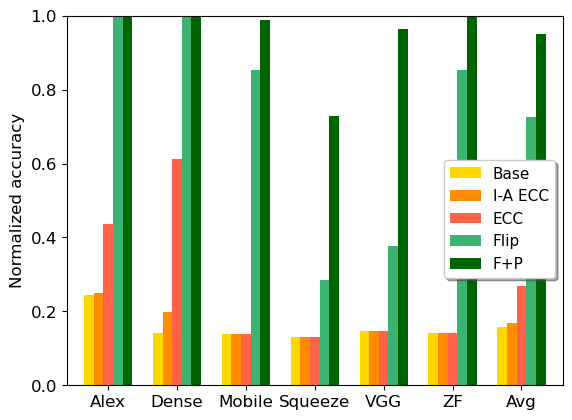

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_base_x4.index)
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
fig = plt.figure(figsize=(20,5), dpi=100)

Resumen_base_x4.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend(  fontsize=11, loc ="center right",bbox_to_anchor=(1.0,0.45), shadow = True)
plt.ylim(0,1.0)
plt.ylabel('Normalized accuracy', fontsize=12)
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, Resumen_base_x4.index, fontsize= 12)
plt.xticks(rotation = 0)

plt.savefig('Resumen_acc_exp_base_x4.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()
#pdfFile=PdfPages("Analizando_fichero_detalle\Alterado_fichero\concretando análisis\gráficos\Resumen_acc_experimentos.pdf")
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()

#


In [ ]:
#poner las redes como el index es decir decir que el index seran las redes

In [28]:
Gráfica_general_técnicas_redes=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Gráfica_general_técnicas_redes.xlsx',sheet_name='Hoja2')
Resumen_mask= Gráfica_general_técnicas_redes.set_index("Tec_red")

In [16]:
Gráfica_general_técnicas_redes=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/Gráfica_general_técnicas_redes.xlsx',sheet_name='Hoja_españ')
Resumen_mask= Gráfica_general_técnicas_redes.set_index("Tec_red")

In [29]:
Resumen_mask

,1x faults,2x faults,3x faults,4x faults
Tec_red,,,,
Base,0.445333,0.310667,0.254667,0.218667
I-A ECC,0.518667,0.325333,0.265333,0.221333
ECC,0.745333,0.649333,0.265333,0.221333
Flip,0.890667,0.892000,0.890667,0.889333
F+P,0.890667,0.892000,0.892000,0.893333
Base,0.660000,0.122667,0.122667,0.122667
I-A ECC,0.712000,0.122667,0.122667,0.122667
ECC,0.910667,0.865333,0.294667,0.180000
Flip,0.914667,0.913333,0.910667,0.912000


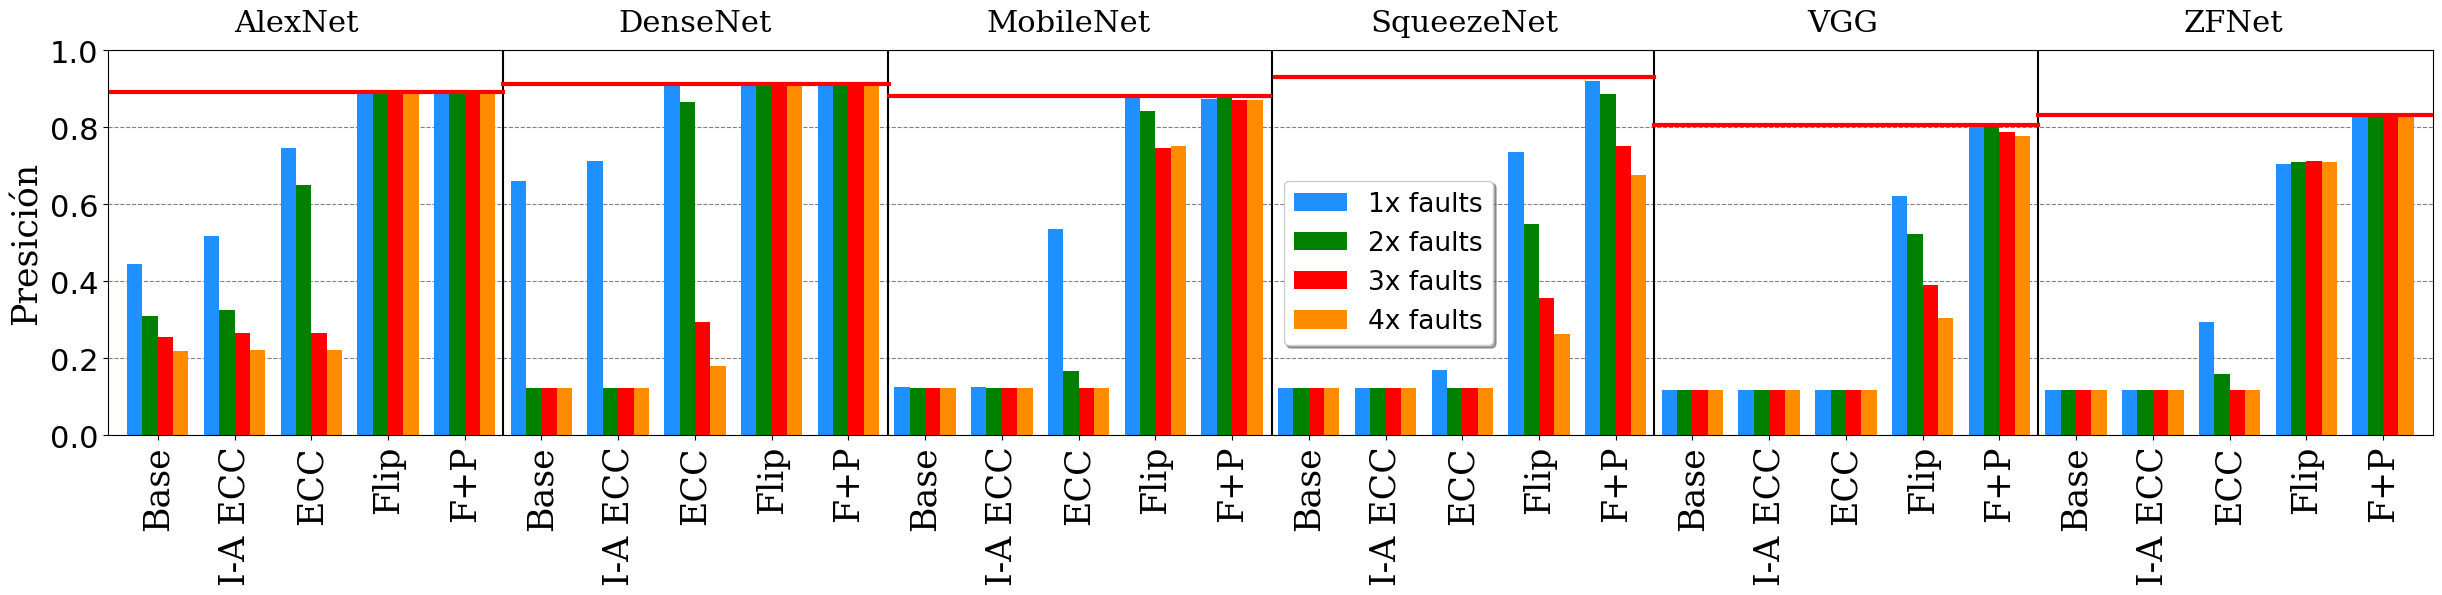

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import seaborn as sns

n = len(Resumen_mask.index)
x = np.arange(n)
#coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
coloresRedes = [ 'dodgerblue','green','red', 'darkorange']


Resumen_mask.plot(kind ='bar', width = 0.80, fontsize=22, color = coloresRedes, figsize=(30,5), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend(  fontsize=19, bbox_to_anchor=(0.5,0.2),shadow = True)
plt.ylim(0,1.0)
plt.ylabel('Presición', fontsize=25, fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') ### colocarlo por detrás de las barras


plt.axvline(x=4.5, ymax= 5, color="black")
plt.axvline(x=9.52, ymax= 5, color="black")
plt.axvline(x=14.52, ymax= 5, color="black")
plt.axvline(x=19.5, ymax= 5, color="black")
plt.axvline(x=24.5, ymax= 5, color="black")

plt.axhline(y=0.8907, xmax= 0.17,             linewidth=3,color="red") #'AlexNet'
plt.axhline(y=0.9133, xmin=0.17, xmax= 0.336, linewidth=3,color="red")#DenseNet
plt.axhline(y=0.8813, xmin=0.336, xmax= 0.50, linewidth=3, color="red")#MobileNet
plt.axhline(y=0.9307, xmin=0.502, xmax= 0.665,linewidth=3,color="red")# SqueezeNet
plt.axhline(y=0.8053, xmin=0.665, xmax= 0.83,linewidth=3, color="red")#VGG
plt.axhline(y=0.8333, xmin=0.83,  xmax= 1,   linewidth=3, color="red")#ZFNet


plt.xlabel('')
plt.xticks(x, Resumen_mask.index, fontsize= 25, fontfamily="serif")
plt.xticks(rotation = 90)
plt.text(1, 1.05, 'AlexNet', fontsize=22, fontfamily="serif")
plt.text(6, 1.05, 'DenseNet', fontsize=22, fontfamily="serif")
plt.text(10.8, 1.05, 'MobileNet', fontsize=22, fontfamily="serif")
plt.text(15.8, 1.05, 'SqueezeNet', fontsize=22, fontfamily="serif")
plt.text(21.5, 1.05, 'VGG', fontsize=22, fontfamily="serif")
plt.text(26.4, 1.05, 'ZFNet', fontsize=22, fontfamily="serif")

#plt.text(1, 0.91, '89.07 %', fontsize=20, fontfamily="serif")
#plt.text(6, 0.93, '91.33 %', fontsize=20, fontfamily="serif")
#plt.text(10.8, 0.90, '88.13 %', fontsize=20, fontfamily="serif")
#plt.text(15.8, 0.95, '93.07 %', fontsize=20, fontfamily="serif")
#plt.text(21.5, 0.82, '80.53 %', fontsize=20, fontfamily="serif")
#plt.text(26.4, 0.85, '83.33 %', fontsize=20, fontfamily="serif")


#plt.savefig('Resumen_acc_exp_mascaras.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()


In [ ]:
ax1.plot(acc_correc_bits["Acc_Alex"], label='AlexNet', color='r', ls='-', lw=l, marker='s', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Dense"], label='DenseNet', color="blueviolet", ls='-', lw=l, marker='D', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Mobile"], label='MobileNet', color="m", ls='-', lw=l, marker='P', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_Sque"], label='SqueezeNet', color="b", ls='-', lw=l, marker='^', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_VGG16"], label='VGG16', color="g", ls='-', lw=l, marker='<', markersize=marksize)
ax1.plot(acc_correc_bits["Acc_ZFNet"], label='ZFNet', color="c", ls='-', lw=l, mark

In [289]:
Gráfica_general_técnicas_redes=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/diferencias_softmax/Prueba_softmax_Redes.xlsx',sheet_name='Resumen')
Resumen_softmax= Gráfica_general_técnicas_redes.set_index("Redes")

In [290]:
Resumen_softmax

,Baseline,Iso-area ECC,ECC,Flip,Flip+Patch
Redes,,,,,
Alex,0.972243,0.857152,0.411888,0.001919,0.001452
Dense,0.501612,0.433701,0.082774,0.010199,0.009472
Mobile,1.712994,1.708563,0.852503,0.071599,0.062368
Squeeze,1.749281,1.749275,1.654127,0.457156,0.077669
VGG,1.529435,1.529435,1.529433,0.473022,0.023040
ZF,1.734443,1.733423,1.244076,0.207653,0.013736


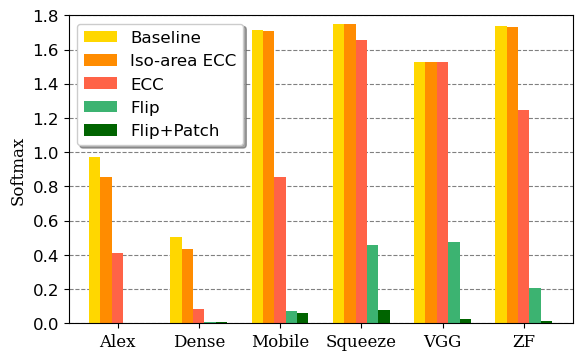

In [335]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(Resumen_softmax.index)
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
#fig = plt.figure(figsize=(15,5), dpi=100)

Resumen_softmax.plot(kind ='bar', width = 0.70, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.legend(  fontsize=12,loc='upper left', shadow = True)
#plt.yticks(range(0,1.80,1))
plt.ylim(0,1.80)
plt.ylabel('Softmax', fontsize=12, fontfamily="serif")
xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, Resumen_softmax.index, fontsize= 12, fontfamily="serif")
plt.xticks(rotation = 0)

plt.grid(axis='y', color = 'gray', linestyle = 'dashed')
plt.savefig('Resumen_softmax.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()



# colocar redes en el eje x parecido a la fig 7

In [39]:
import pandas as pd
energía=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/energía/Eventos energía_xRedes_ruben_final.xlsx',sheet_name='Hoja2', )
energía_redes=energía.set_index("Vol")

In [68]:
import pandas as pd
energía_esp=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/energía/Eventos energía_xRedes_ruben_final.xlsx',sheet_name='energia_esp', )
energía_redes_esp=energía_esp.set_index("Vol")

In [69]:
energía_redes_esp

,Redes,Leakage,Leakage Sbc,Lecturas,Lect Sbc,Escrituras,Esc Sbc
Vol,,,,,,,
DVS,AlexNet,0.057819,0.000000,0.941993,0.000000,0.000187,0.000000
V+R,NaN,0.049530,0.004168,0.725343,0.075667,0.000136,0.000016
DVS,DenseNet,0.902830,0.000000,0.074334,0.000000,0.022836,0.000000
V+R,NaN,0.773504,0.065095,0.057238,0.005972,0.016512,0.001950
DVS,MobileNet,0.761471,0.000000,0.225966,0.000000,0.012563,0.000000
V+R,NaN,0.652367,0.054900,0.173996,0.018151,0.009083,0.001072
DVS,SqueezeNet,0.936180,0.000000,0.043373,0.000000,0.020447,0.000000
V+R,NaN,0.802012,0.067494,0.033397,0.003484,0.014784,0.001746
DVS,VGG16,0.139067,0.000000,0.860644,0.000000,0.000289,0.000000


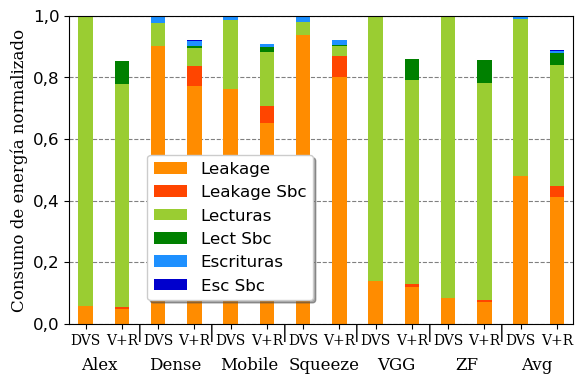

In [71]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
n = len(energía_redes_esp.index)
x = np.arange(n)
coloresRedes = ['darkorange','orangered','yellowgreen','green',  'dodgerblue','mediumblue']
#coloresRedes = [ 'gold','springgreen','lime','mediumseagreen', 'darkgreen']
#fig = plt.figure(figsize=(15,5), dpi=100)

energía_redes_esp.plot(kind ='bar', stacked=True, width = 0.40, fontsize=12, color = coloresRedes, figsize=(6.5,4), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
plt.hlines(3,2,5,color="red")
plt.legend(  fontsize=12,bbox_to_anchor=(0.5,0.05), shadow = True)
#plt.yticks(range(0,1.80,1))
plt.ylim(0,1)
plt.ylabel('Consumo de energía normalizado', fontsize=12, fontfamily="serif")
plt.xlabel('')
#plt.bar(total.index  , total)
plt.xticks(x, energía_redes_esp.index, fontsize= 10, fontfamily="serif")
plt.yticks(np.arange(0, 1.02, step=0.2), ('0,0', '0,2', '0,4', '0,6','0,8','1,0'))
plt.xticks(rotation = 0)
plt.grid(axis='y', color = 'gray', linestyle = 'dashed')

plt.text(1.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(3.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(5.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(7.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(9.4, -0.046, '|', fontsize=12, fontfamily="serif")
plt.text(11.4, -0.046, '|', fontsize=12, fontfamily="serif")




plt.text(-0.12, -0.15, 'Alex', fontsize=12, fontfamily="serif")
plt.text(1.75, -0.15, 'Dense', fontsize=12, fontfamily="serif")
plt.text(3.7, -0.15, 'Mobile', fontsize=12, fontfamily="serif")
plt.text(5.6,-0.15, 'Squeeze', fontsize=12, fontfamily="serif")
plt.text(8.05, -0.15, 'VGG', fontsize=12, fontfamily="serif")
plt.text(10.2, -0.15, 'ZF', fontsize=12, fontfamily="serif")
plt.text(12, -0.15, 'Avg', fontsize=12, fontfamily="serif")
plt.savefig('energia.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)






In [127]:
voltajes_redes=pd.read_excel('Analizando_fichero_detalle/Alterado_fichero/concretando análisis/Resumen_acc_exp_todos los voltajes_y redes.xlsx',sheet_name='graficar')
voltajes_redes_index= voltajes_redes.set_index("voltajes")

In [128]:
voltajes_redes_index

,Baseline,I-A ECC,ECC,Flip,F + P
voltajes,,,,,
0.58,1.000000,1.000000,1.000000,1.000000,1.000000
0.56,0.844311,0.850299,1.005988,1.000000,1.000000
0.54,0.500000,0.582335,0.836826,1.000000,1.000000
0.58,0.998544,1.000000,1.000000,1.000000,1.000000
0.55,1.000000,1.000000,1.002911,1.000000,1.000000
0.54,0.720524,0.777293,0.994178,0.998544,1.000000
0.58,0.996974,1.004539,1.000000,1.001513,1.001513
0.56,0.704992,0.715582,0.897126,1.000000,1.000000
0.54,0.142209,0.142209,0.609682,0.998487,0.992436


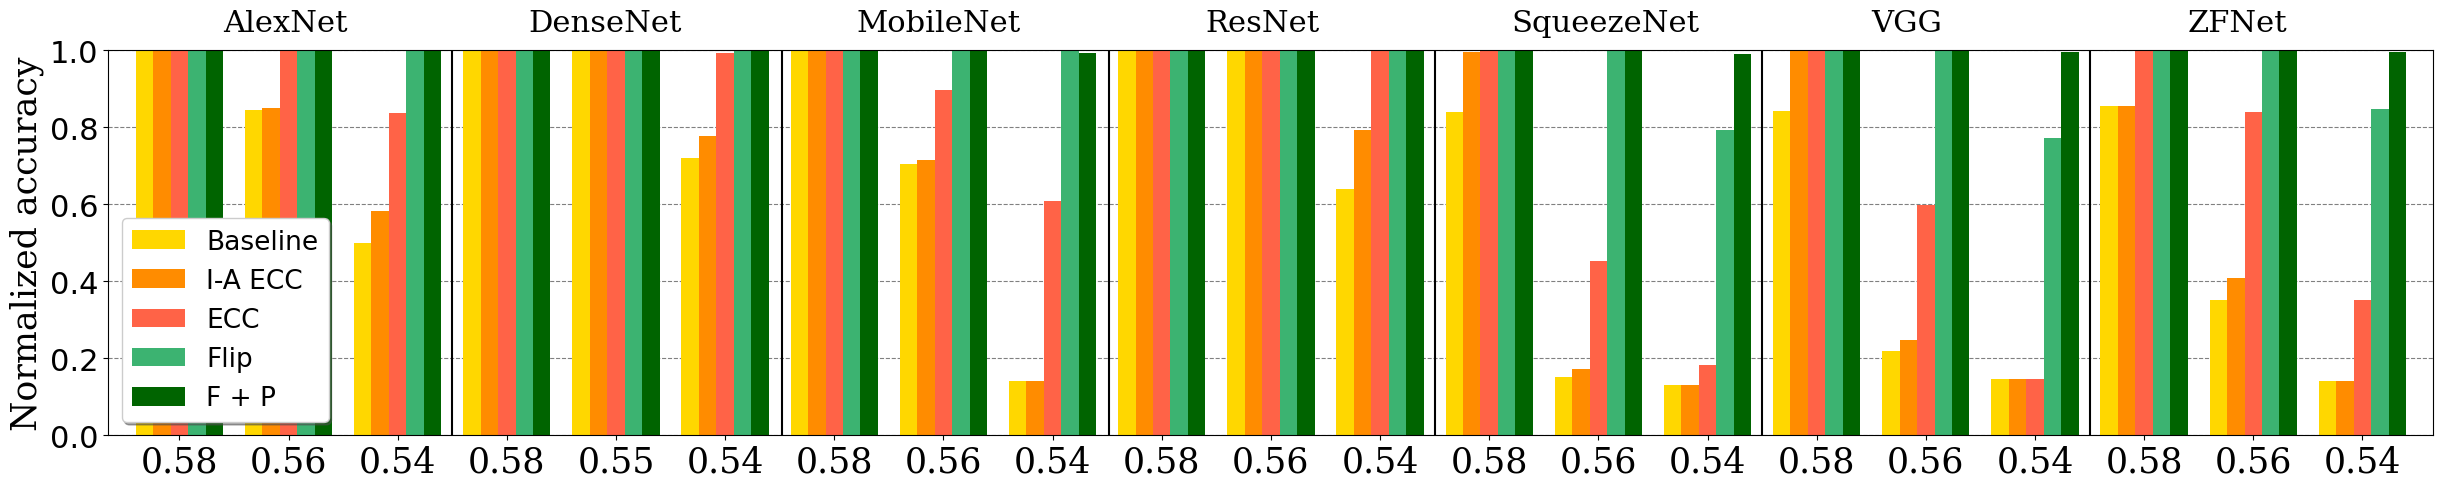

In [138]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages, PdfFile
import seaborn as sns

n = len(voltajes_redes_index.index)
x = np.arange(n)
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']



voltajes_redes_index.plot(kind ='bar', width = 0.80, fontsize=22, color = coloresRedes, figsize=(30,5), zorder=2 );
#fig.legend(fontsize=12, loc ="lower right", shadow = True)
#plt.legend(  fontsize=19, bbox_to_anchor=(0.75,0.1),shadow = True)
plt.legend(  fontsize=19, loc='lower left',shadow = True)

plt.ylim(0,1.0)
plt.ylabel('Normalized accuracy', fontsize=25, fontfamily="serif")
plt.grid(axis='y', color = 'gray', linestyle = 'dashed') ### colocarlo por detrás de las barras


plt.axvline(x=2.5, ymax= 5, color="black")
plt.axvline(x=5.52, ymax= 5, color="black")
plt.axvline(x=8.52, ymax= 5, color="black")
plt.axvline(x=11.5, ymax= 5, color="black")
plt.axvline(x=14.5, ymax= 5, color="black")
plt.axvline(x=17.5, ymax= 5, color="black")

#plt.axhline(y=0.8907, xmax= 0.17,             linewidth=3,color="red") #'AlexNet'
#plt.axhline(y=0.9133, xmin=0.17, xmax= 0.336, linewidth=3,color="red")#DenseNet
#plt.axhline(y=0.8813, xmin=0.336, xmax= 0.50, linewidth=3, color="red")#MobileNet
#plt.axhline(y=0.9307, xmin=0.502, xmax= 0.665,linewidth=3,color="red")# SqueezeNet
#plt.axhline(y=0.8053, xmin=0.665, xmax= 0.83,linewidth=3, color="red")#VGG
#plt.axhline(y=0.8333, xmin=0.83,  xmax= 1,   linewidth=3, color="red")#ZFNet


plt.xlabel('')
plt.xticks(x, voltajes_redes_index.index, fontsize= 25, fontfamily="serif")
plt.xticks(rotation = 0)
plt.text(0.4, 1.05, 'AlexNet', fontsize=22, fontfamily="serif")
plt.text(3.2, 1.05, 'DenseNet', fontsize=22, fontfamily="serif")
plt.text(6.2, 1.05, 'MobileNet', fontsize=22, fontfamily="serif")
plt.text(9.4, 1.05, 'ResNet', fontsize=22, fontfamily="serif")
plt.text(12.2, 1.05, 'SqueezeNet', fontsize=22, fontfamily="serif")
plt.text(15.5, 1.05, 'VGG', fontsize=22, fontfamily="serif")
plt.text(18.4, 1.05, 'ZFNet', fontsize=22, fontfamily="serif")

#plt.text(1, 0.91, '89.07 %', fontsize=20, fontfamily="serif")
#plt.text(6, 0.93, '91.33 %', fontsize=20, fontfamily="serif")
#plt.text(10.8, 0.90, '88.13 %', fontsize=20, fontfamily="serif")
#plt.text(15.8, 0.95, '93.07 %', fontsize=20, fontfamily="serif")
#plt.text(21.5, 0.82, '80.53 %', fontsize=20, fontfamily="serif")
#plt.text(26.4, 0.85, '83.33 %', fontsize=20, fontfamily="serif")


plt.savefig('voltajes_redes.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

plt.show()
#pdfFile.savefig(fig, transparent = True, bbox_inches = 'tight', pad_inches = 0)
#pdfFile.close()


In [ ]:
#Para presentación

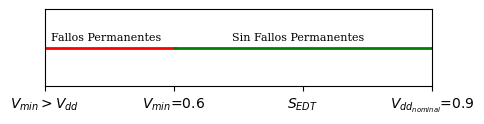

In [96]:
import matplotlib.pyplot as plt
x="${V_{min} > V_{dd}}$","$V_{min}$=0.6", "$S_{EDT}$", "$V_{dd_{nominal}}$=0.9"
plt.figure(figsize=(5,1))
plt.ylim(0,1)
#ax = plt.axes()
#ax.spines['left'].set_visible(False)
x_values = range(len(x))
#plt.axis('off')

plt.yticks([])
plt.xticks(x_values, x)
plt.axhline(y=0.5, xmin=0, xmax= 0.336, linewidth=2,color="red")#DenseNet
plt.axhline(y=0.5, xmin=0.336, xmax= 1, linewidth=2,color="g")#DenseNet
#plt.legend(  fontsize=12, shadow = True)
plt.text(1.45, 0.6, 'Sin Fallos Permanentes', fontsize=8, fontfamily="serif")
plt.text(0.05, 0.6, 'Fallos Permanentes', fontsize=8, fontfamily="serif")

  
# rendering the plot
plt.show()

In [ ]:
#Errores voltajes

C:\Users\usuario\AppData\Local\Temp\ipykernel_13484\3732649229.py:10: UserWarning:

FixedFormatter should only be used together with FixedLocator



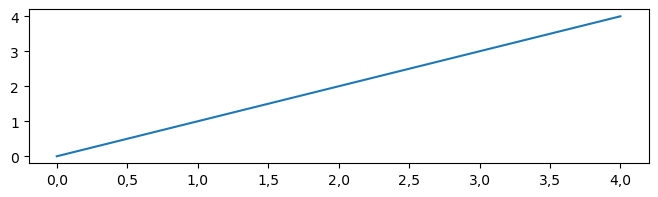

In [20]:
import matplotlib.pyplot as plt
from matplotlib import ticker

#fig, ax = plt.subplots(1, 1, figsize=(8, 2))
#ax.plot(range(0, 5), range(0, 5))
#ax.xaxis.set_major_formatter(ticker.FormatStrFormatter("%.1f"))
#plt.show()
#
fig, ax = plt.subplots(1, 1, figsize=(8, 2))
ax.set_xticklabels(['0,0', '0,0', '0,5', '1,0', '1,5', '2,0', '2,5', '3,0', '3,5', '4,0',])
ax.plot(range(0, 5), range(0, 5))
plt.show()


# Diagrama de cajas y Bigotes

In [ ]:

mediana
Q1. mediana del grupo d enumeros menosres
Q2. mediana de todo el conjunto de numeros
Q3. mediana del grupo d enumeros mayores 
Donde la caja es mas ancha quiere decir que el rango entre los numeros es mayor para ese costado de la mediana
valor max
valor min
rango= valor max - valor min
rango_intercuartil(IQR):distancia entre los dos extremos de la caja
Q1 = 25 % valor donde comienza la caja
Q2 = 50%  valor de la mediana
Q3 = 75 % valor donde finaliza la caja
IQR= Q3-Q1



In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.colors as mcolors



In [42]:
AlexNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\AlexNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
AlexNet

,Base,I-A ECC,ECC,Flip,F + P
0,1.957557,1.957090,1.895195,0.000946,1.081649e-03
1,1.982833,1.957071,0.242701,0.000214,1.433329e-04
2,0.010073,0.012053,0.039729,0.000007,1.424039e-04
3,0.032458,0.032167,0.026965,0.000031,3.803965e-07
4,1.300976,0.568596,0.171837,0.005084,2.486014e-03
...,...,...,...,...,...
745,1.334329,1.040370,0.108300,0.000701,1.032325e-03
746,0.830131,0.875881,0.160765,0.000955,2.096470e-03
747,1.363894,1.260764,0.522994,0.003193,3.270345e-03
748,1.696105,1.840787,0.709911,0.001856,2.180753e-03


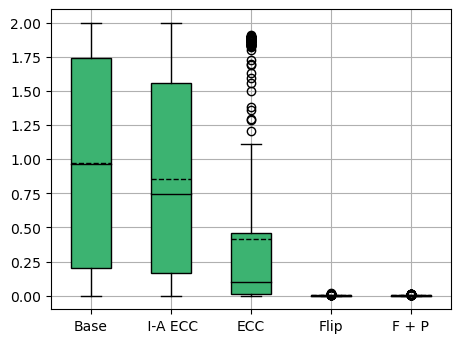

In [43]:

 
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 7))
ax = fig.add_axes([0, 0, 1, 1])
fig.set_size_inches(4, 3)
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
bplot=ax.boxplot(AlexNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'],showmeans = True,
                 boxprops = dict(facecolor = "mediumseagreen"),
                 medianprops = dict(color = "black", linewidth = 1),
                 meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = True, showfliers=True)
plt.grid(True)
#bplot=plt.boxplot(data)
#outliers_ECC = bplot["fliers"][2].get_ydata()
#outliers_filp = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_ECC',len(outliers_ECC))
#print('outliers_F',len(outliers_filp))
#print('outliers_F_P',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
#    outliers = bplot["fliers"][idx].get_ydata()
#    print(idx)
#plt.savefig('AlexNet_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
# show plot
plt.show()

In [46]:
print(np.min(AlexNet))
print(np.quantile(AlexNet, 0.25))
print(np.quantile(AlexNet,0.75))
print(np.mean(AlexNet))

Base       1.906461e-06
I-A ECC    4.136796e-07
ECC        3.269339e-08
Flip       7.026499e-09
F + P      2.865207e-10
dtype: float64
0.0007510464929509908
0.7220373898744583
Base       0.972243
I-A ECC    0.857152
ECC        0.411888
Flip       0.001919
F + P      0.001452
dtype: float64


# Prueba de Tukey

ValueError: Can only compare identically-labeled Series objects

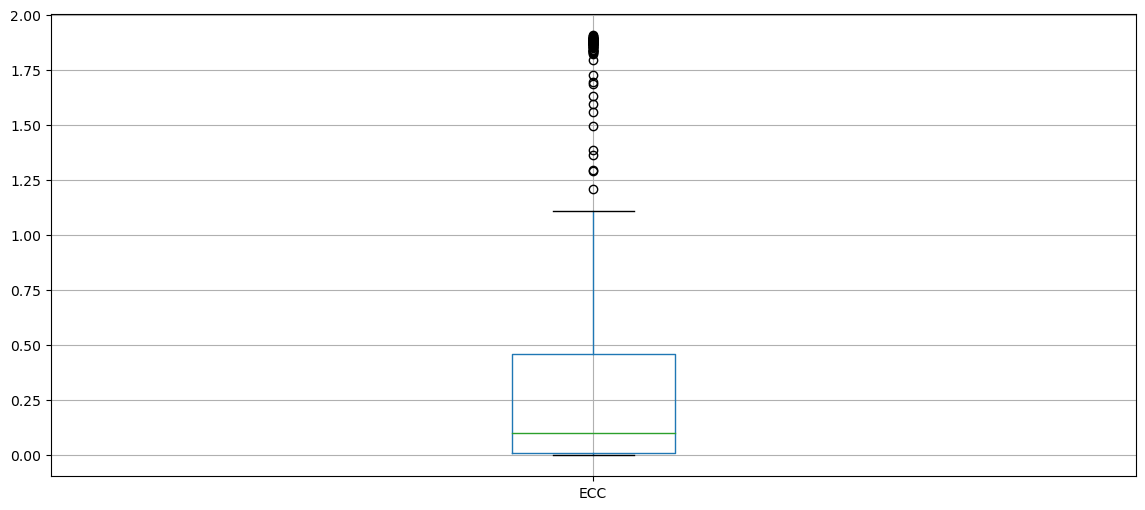

In [85]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
plt.rc('figure',figsize = (14,6))

datos =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\AlexNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")

datos.head(10)

datos.boxplot(['ECC'])

datos[datos['ECC'] >= 6]

ECC = datos['ECC']

#Q1 = valor.quantile(.25)
#Q3 = valor.quantile(.75)
#IIQ = Q3 - Q1
#limite_inf = Q1 - 1.5 * IIQ 
#limite_sup = Q3 + 1.5 * IIQ
#
seleccion = ((ECC >= limite_inf) & (ECC <= limite_sup))

datos_new = datos[seleccion]

#datos_new.boxplot(['ECC'])

#datos.hist(['ECC'])

#datos_new.hist(['ECC'])

#datos.boxplot(['ECC'],by = ['ECC'])

#grupo_tipo = datos.groupby('ECC')['ECC']
#
#type(grupo_tipo)

pd.core.groupby.generic.SeriesGroupBy

#grupo_tipo.groups

Q1 = datos.quantile(.25)
Q3 = datos.quantile(.75)
IIQ = Q3 - Q1
limite_inf = Q1 - 1.5 * IIQ 
limite_sup = Q3 + 1.5 * IIQ

Q1

limite_inf

datos_new = pd.DataFrame()
for tipo in datos:
    eh_tipo = datos['ECC'] == tipo
    eh_dentro_limite = (datos['ECC'] >= limite_inf[tipo]) & (datos['ECC'] <= limite_sup[tipo])
    seleccion = eh_tipo & eh_dentro_limite
    datos_seleccion = datos[seleccion]
    datos_new = pd.concat([datos_new,datos_seleccion])
  
 #datos_new.boxplot(['ECC'],by = ['Tipo'])
datos_new.boxplot(['ECC'])


#datos_new.to_csv('alquiler_residencial_sin_outliers.csv',sep = ';',index = False)

#**Extra**

#%matplotlib inline
#import pandas as pd
#import matplotlib.pyplot as plt
#plt.rc('figure',figsize = (25,20))
#
#datos = pd.read_csv('alquiler_residencial_sin_outliers.csv',sep = ';')
#datos.head(10)
#
#area = plt.figure()
#
#g1 = area.add_subplot(2,2,1)
#g2 = area.add_subplot(2,2,2)
#g3 = area.add_subplot(2,2,3)
#g4 = area.add_subplot(2,2,4)
#
##Crear Graficos
#g1.scatter(datos.Valor,datos.Area)
#g1.set_title('VAlor por Area')
#
#g2.hist(datos.Valor)
#g2.set_title('Histograma')
#
#datos_g3 = datos.Valor.sample(100)
#datos_g3.index = range(datos_g3.shape[0])
#g3.plot(datos_g3)
#g3.set_title('Muestra de columna "Valor"')
#
#grupo = datos.groupby('Tipo')['Valor']
#label = grupo.mean().index
#valores = grupo.mean().values
#g4.bar(label,valores)
#g4.set_title('Valor medio por Tipo')
#
#area
#
#area.savefig('graficos.png',dpi = 300, bbox_inches = 'tight')

In [61]:
DenseNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\DenseNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
DenseNet

,Base,I-A ECC,ECC,Flip,F + P
0,1.040413,0.855657,0.126635,0.029790,0.028101
1,1.094519,1.108753,0.018075,0.000699,0.000524
2,0.639126,0.059735,0.248525,0.037764,0.060538
3,0.031287,0.028919,0.016494,0.006661,0.004734
4,0.998374,0.624537,0.006240,0.000118,0.000102
...,...,...,...,...,...
745,0.025814,0.010245,0.010629,0.001657,0.002856
746,1.640232,1.502931,0.061477,0.002900,0.002466
747,0.013978,0.009995,0.002388,0.001238,0.000946
748,1.789022,1.649746,0.066019,0.020072,0.021020


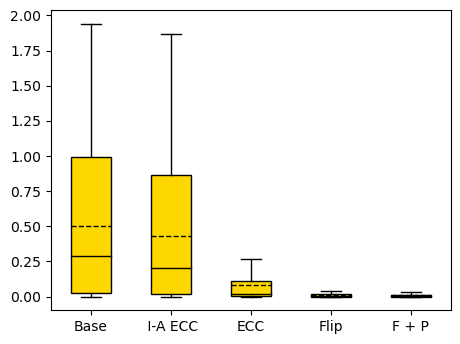

In [62]:

coloresRedes = ['gold', 'darkorange','yellow','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 7))
fig.set_size_inches(4, 3)

ax = fig.add_axes([0, 0, 1, 1])
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
#bplot=ax.boxplot(DenseNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'], patch_artist=True, showfliers=False)
bplot=ax.boxplot(DenseNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'],showmeans = True,
                 boxprops = dict(facecolor = "gold"),
                 medianprops = dict(color = "black", linewidth = 1),
                 meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = True, showfliers=False)
#bplot=plt.boxplot(data)
#outliers_ECC = bplot["fliers"][2].get_ydata()
#outliers_filp = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_ECC',len(outliers_ECC))
#print('outliers_F',len(outliers_filp))
#print('outliers_F_P',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
 
# show plot
plt.savefig('DenseNet_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)
plt.show()

In [26]:
MobileNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\MobileNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
MobileNet

,Base,I-A ECC,ECC,Flip,F + P
0,1.999915,1.999724,1.982022,0.001617,0.004397
1,1.999113,1.999479,0.293541,0.002260,0.001222
2,1.201488,1.214380,1.115012,0.506061,0.152326
3,1.327197,1.415428,1.243783,0.227046,0.140585
4,1.999766,1.999529,0.086690,0.001105,0.000743
...,...,...,...,...,...
745,1.969888,1.970635,1.138805,0.011819,0.003955
746,1.999344,1.998982,0.089746,0.040117,0.051783
747,1.692380,1.758789,0.295941,0.046503,0.021200
748,1.778501,1.507519,1.362183,0.220926,0.291389


In [28]:
df = MobileNet.transpose( )
df

,0,1,2,3,4,5,6,7,8,9,...,740,741,742,743,744,745,746,747,748,749
Base,1.999915,1.999113,1.201488,1.327197,1.999766,1.999579,1.816177,1.573990,1.955391,1.998689,...,1.974472,1.879873,1.986286,1.991930,1.948862,1.969888,1.999344,1.692380,1.778501,1.991439
I-A ECC,1.999724,1.999479,1.214380,1.415428,1.999529,1.999553,1.748328,1.525031,1.955302,1.995515,...,1.974833,1.878101,1.986357,1.973584,1.948959,1.970635,1.998982,1.758789,1.507519,1.991344
ECC,1.982022,0.293541,1.115012,1.243783,0.086690,1.962036,0.057894,0.460061,1.524754,0.500833,...,1.144883,1.541333,0.791528,0.096355,1.197870,1.138805,0.089746,0.295941,1.362183,1.421323
Flip,0.001617,0.002260,0.506061,0.227046,0.001105,0.026542,0.045928,0.079829,0.159876,0.006905,...,0.035364,0.089878,0.095892,0.183797,0.020057,0.011819,0.040117,0.046503,0.220926,0.142608
F + P,0.004397,0.001222,0.152326,0.140585,0.000743,0.025174,0.015718,0.212507,0.150534,0.002964,...,0.032688,0.009820,0.197521,0.211817,0.016282,0.003955,0.051783,0.021200,0.291389,0.071329


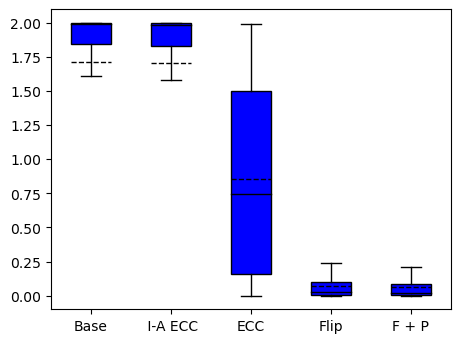

In [65]:
coloresRedes = ['gold', 'darkorange','yellow','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 7))
fig.set_size_inches(4, 3)

ax = fig.add_axes([0, 0, 1, 1])
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
#bplot=ax.boxplot(MobileNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'], patch_artist=True)
bplot=ax.boxplot(MobileNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'],showmeans = True,
                 boxprops = dict(facecolor = "b"),
                 medianprops = dict(color = "black", linewidth = 1),
                 meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = True, showfliers=False)
plt.savefig('MobileNet_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

#bplot=plt.boxplot(data)
#outliers_ECC = bplot["fliers"][2].get_ydata()
#outliers_filp = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_ECC',len(outliers_ECC))
#print('outliers_F',len(outliers_filp))
#print('outliers_F_P',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
# 
# show plot

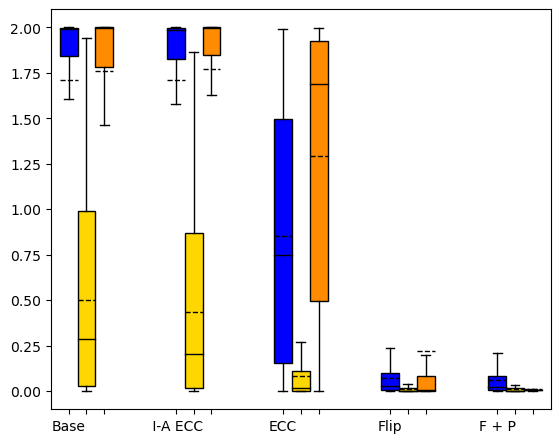

In [29]:
MobileNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\MobileNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
MobileNet.transpose( )


DenseNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\DenseNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
DenseNet

ZFNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\ZFNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
ZFNet

SqueezeNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\SqueezeNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')


fig = plt.figure(figsize =(10, 7))
fig.set_size_inches(5, 4)

ax = fig.add_axes([0, 0, 1, 1])

nets_width = 3.0
box_width = 0.5
experiments = 5

nets = []
nets.append(MobileNet)
nets.append(DenseNet)
nets.append(ZFNet)
#nets.append(SqueezeNet)

colors = ["b", "gold", "darkorange", "r"]
full_label = ['Base',' I-A ECC','ECC','Flip','F + P']
empty_label = ['','','','','']

for i, net in enumerate(nets):
    
    color = colors[i]
    label = full_label if 0 == i else empty_label
    
    bplot = ax.boxplot(net,
                       labels=label,
                       positions=np.array(range(experiments)) * nets_width + i * box_width,
                       showmeans = True,
                       boxprops = dict(facecolor = color),
                       medianprops = dict(color = "black", linewidth = 1),
                       meanprops = dict(color = "black", linewidth = 1),
                       patch_artist=True,
                       meanline = True,
                       showfliers = False)

#plt.savefig('MobileNet_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

#bplot = ax.boxplot(DenseNet,
#                   labels=['',' ','','',''],
#                   positions=np.array(range(5)) * seq_width + 1 * box_width,
#                   showmeans = True,
#                   boxprops = dict(facecolor = "gold"),
#                   medianprops = dict(color = "black", linewidth = 1),
#                   meanprops = dict(color = "black", linewidth = 1),
#                   patch_artist=True,
#                   meanline = True,
#                   showfliers = False)



#for (i, variant) in zip(range(len(self.variants)), self.variants):
#            
#            seq_lengths = self.seq_lengths if 0 == i else empty_seq_lengths
#            
#            # boxplots[variant] = ax.boxplot([errors_per_length[variant][seq] for seq in self.seq_lengths], 
#            #                            positions=np.array(range(len(self.seq_lengths))) * self.lengths_scale + i * self.bar_width,
#            #                            labels= seq_lengths,
#            #                            sym='',
#            #                            widths=self.bar_width,
#            #                            patch_artist=True)
#            
#            boxplots[variant] = ax.boxplot([errors_per_length[variant][seq] for seq in self.seq_lengths], 
#                                        positions=np.array(range(len(self.seq_lengths))) * self.lengths_scale + i * self.bar_width,
#                                       labels= seq_lengths,
#                                       sym='',
#                                        widths=self.bar_width,
#                                       patch_artist=True)

In [30]:
ZFNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\ZFNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
ZFNet

,Base,I-A ECC,ECC,Flip,F + P
0,1.999170,1.999150,1.923924,1.422451,0.017246
1,1.999170,1.999150,1.923924,1.422451,0.007024
2,1.999990,1.999862,1.856279,0.039858,0.014781
3,1.999990,1.999862,1.856279,0.039858,0.007024
4,0.995124,1.801629,1.945896,0.003835,0.032139
...,...,...,...,...,...
745,1.982675,1.982692,1.970541,0.003163,0.007024
746,1.994149,1.994181,0.602489,0.031137,0.007962
747,1.994149,1.994181,0.602489,0.031137,0.007024
748,1.998092,1.997853,1.914711,1.368589,0.056942


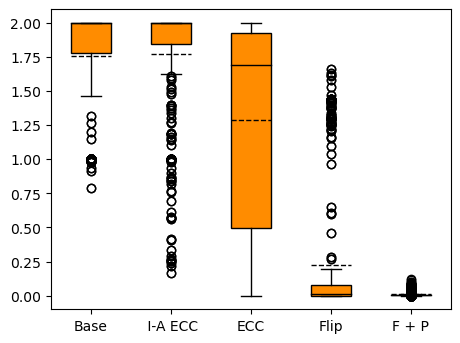

In [31]:
coloresRedes = ['gold', 'darkorange','yellow','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 7))
fig.set_size_inches(4, 3)

ax = fig.add_axes([0, 0, 1, 1])
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
#bplot=ax.boxplot(ZFNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'], patch_artist=True)
bplot=ax.boxplot(ZFNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'],showmeans = True,
                 boxprops = dict(facecolor = "darkorange"),
                 medianprops = dict(color = "black", linewidth = 1),
                 meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = True, showfliers=True)
plt.savefig('ZFNet_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

#bplot=plt.boxplot(data)
#outliers_base = bplot["fliers"][0].get_ydata()
#outliers_I_F = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_base',len(outliers_ECC))
#print('outliers_I_F',len(outliers_filp))
#print('outliers_F_p',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
# 

In [68]:
SqueezeNet =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\SqueezeNet_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
SqueezeNet

,Base,I-A ECC,ECC,Flip,F + P
0,2.000000,2.000000,1.999999,1.983297,0.010320
1,1.999985,1.999985,1.999985,0.005914,0.000042
2,0.073711,0.073728,1.995313,0.068703,0.039729
3,0.031660,0.031674,1.969537,0.024552,0.009110
4,2.000000,2.000000,2.000000,0.000142,0.000013
...,...,...,...,...,...
745,2.000000,2.000000,0.000458,0.007483,0.000097
746,1.999985,1.999995,1.999991,0.002827,0.000136
747,1.999508,1.999523,1.973775,0.018725,0.023983
748,1.999977,1.999992,1.990906,1.437104,0.508663


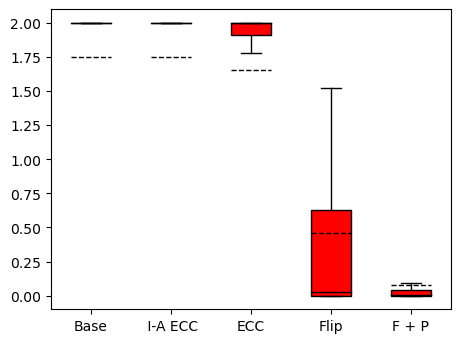

In [69]:
coloresRedes = ['gold', 'darkorange','yellow','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 7))
fig.set_size_inches(4, 3)

ax = fig.add_axes([0, 0, 1, 1])
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
#bplot=ax.boxplot(ZFNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'], patch_artist=True)
bplot=ax.boxplot(SqueezeNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'],showmeans = True,
                 boxprops = dict(facecolor = "r"),
                 medianprops = dict(color = "black", linewidth = 1),
                 meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = True, showfliers=False)
plt.savefig('SqueezNet_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

#bplot=plt.boxplot(data)
#outliers_base = bplot["fliers"][0].get_ydata()
#outliers_I_F = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_base',len(outliers_ECC))
#print('outliers_I_F',len(outliers_filp))
#print('outliers_F_p',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
# 

In [70]:
VGG16 =pd.read_excel('Analizando_fichero_detalle\Alterado_fichero\concretando análisis\diferencias_softmax\VGG16_diff_softmax_imagenes.xlsx',sheet_name='softmax_exp')
#data= data.set_index("df_experimentos")
VGG16

,Base,I-A ECC,ECC,Flip,F + P
0,1.999764,1.999764,1.999756,1.808483,0.025908
1,1.992171,1.992171,1.992171,0.099040,0.008158
2,1.036821,1.036821,1.036821,0.303873,0.024107
3,1.362626,1.362626,1.362626,0.050959,0.001961
4,1.999705,1.999705,1.999704,0.123410,0.001749
...,...,...,...,...,...
745,1.231604,1.231604,1.231604,1.079463,0.080934
746,1.818879,1.818879,1.818879,0.239635,0.001885
747,0.820854,0.820854,0.820854,0.264132,0.032794
748,1.470904,1.470904,1.470904,0.244493,0.007544


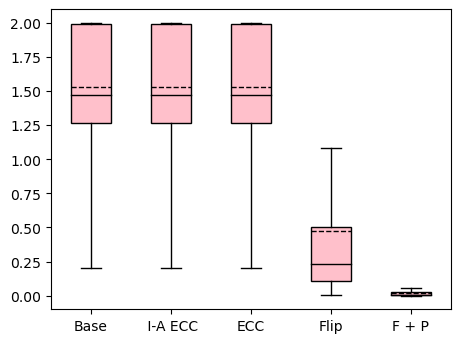

In [71]:
coloresRedes = ['gold', 'darkorange','yellow','mediumseagreen', 'darkgreen']



fig = plt.figure(figsize =(10, 7))
fig.set_size_inches(4, 3)

ax = fig.add_axes([0, 0, 1, 1])
 
# Creating axes instance
#ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
#bp = ax.boxplot(data)
#bplot=ax.boxplot(ZFNet,labels=['Base',' I-A ECC','ECC','Flip','F + P'], patch_artist=True)
bplot=ax.boxplot(VGG16,labels=['Base',' I-A ECC','ECC','Flip','F + P'],showmeans = True,
                 boxprops = dict(facecolor = "pink"),
                 medianprops = dict(color = "black", linewidth = 1),
                 meanprops = dict(color = "black", linewidth = 1),
                 patch_artist=True,meanline = True, showfliers=False)
plt.savefig('VGG16_boxes_wisker.pdf', transparent = True, bbox_inches = 'tight', pad_inches = 0)

#bplot=plt.boxplot(data)
#outliers_base = bplot["fliers"][0].get_ydata()
#outliers_I_F = bplot["fliers"][3].get_ydata()
#outliers_F_P = bplot["fliers"][4].get_ydata()
#print('outliers_base',len(outliers_ECC))
#print('outliers_I_F',len(outliers_filp))
#print('outliers_F_p',len(outliers_F_P))
#for idx, box in enumerate(bplot["boxes"]):
#    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])

In [16]:
import numpy as np
import matplotlib.colors as mcolors
data_1 = np.random.normal(100, 10, 200)
data_2 = np.random.normal(90, 20, 200)
data_3 = np.random.normal(80, 30, 200)
data_4 = np.random.normal(70, 40, 200)

[]
0


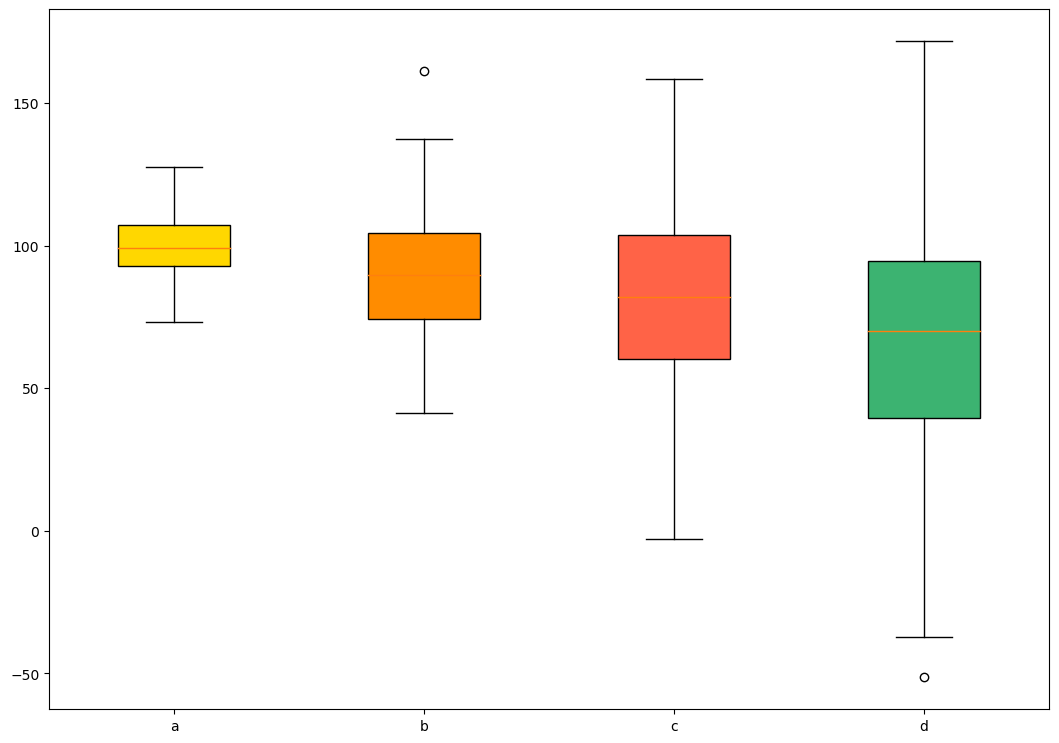

In [21]:
coloresRedes = ['gold', 'darkorange','tomato','mediumseagreen', 'darkgreen']
data = [data_1, data_2, data_3, data_4]
data
 
fig = plt.figure(figsize =(10, 7))
# 
## Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# 
## Creating plot
bplot=ax.boxplot(data,labels=['a','b','c','d'], patch_artist=True)

outliers = bplot["fliers"][0].get_ydata()
print((outliers))
print(len(outliers))
#bp = ax.boxplot(data)
# for
#boxes = bplot["boxes"][0].set_facecolor('b')

for idx, box in enumerate(bplot["boxes"]):
    bplot["boxes"][idx].set_facecolor(coloresRedes[idx])
    #box.set_facecolor(coloresRedes[0])

#boxes = bplot["boxes"][0]
#print(boxes)
#boxes.set_facecolor(mcolors.CSS4_COLORS['darkorange'])
## show plot
plt.show()

In [5]:
b1 = np.random.randn(100) - 1
b2 = np.random.randn(100) + 1

{'whiskers': [<matplotlib.lines.Line2D at 0x1bffb6cafd0>,
 'caps': [<matplotlib.lines.Line2D at 0x1bffb6db490>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bffb6cad00>],
 'medians': [<matplotlib.lines.Line2D at 0x1bffb6dba30>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bffb6dbd00>],
 'means': []}

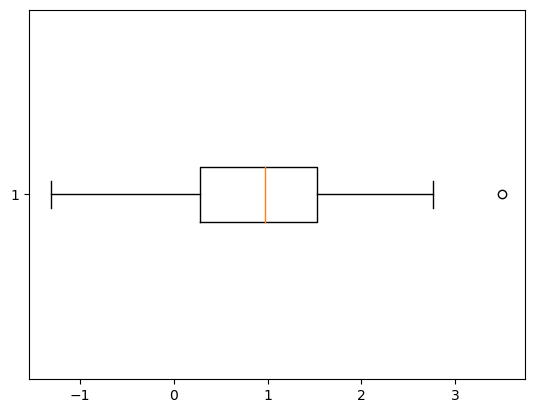

In [33]:
plt.boxplot(x = b2, vert = False)

{'whiskers': [<matplotlib.lines.Line2D at 0x1bffb72ea30>,
 'caps': [<matplotlib.lines.Line2D at 0x1bffb72eeb0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1bffb72e760>],
 'medians': [<matplotlib.lines.Line2D at 0x1bffb73c4c0>],
 'fliers': [<matplotlib.lines.Line2D at 0x1bffb73c790>],
 'means': []}

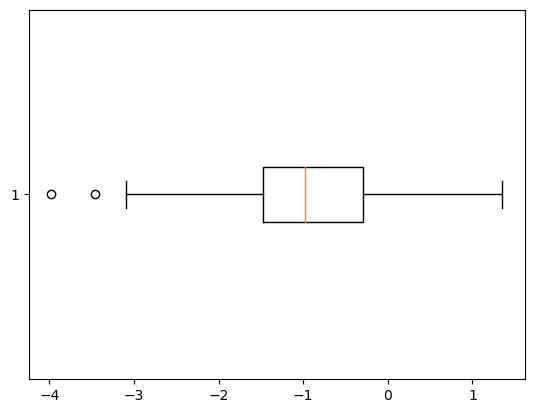

In [34]:
plt.boxplot(x = b1, vert = False)